In [90]:
#БЛОК 1
#Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import seaborn as sns
from tabulate import tabulate
import joblib
import itertools
from deap import base, creator, tools, algorithms
import random

warnings.filterwarnings('ignore')

In [91]:
#Все функции

In [92]:
#БЛОК 2
#Удаляем те игры, в которых ID team = !2
def remove_invalid_games(df):
    
    # группируем данные по номру игры
    grouped_data = df.groupby('ID game')
    
    # список для хранения номеров игр, которые нужно удалить
    games_to_delete = []

    # Проверяем кол-во уникальных команд для каждой игры
    for name, group in grouped_data:
        if group['ID team'].nunique() != 2:
            games_to_delete.append(name)

    # Удаляем игры
    cleaned_data = df[~df['ID game'].isin(games_to_delete)]
    
    # Подсчет кол-ва удаленных игр
    removed_games_count = len(games_to_delete)
    
    # Подсчет общего кол-ва игр до удаления
    total_games_before = len(df['ID game'].unique())
    
    # Подсчет общего кол-ва игр после удаления
    total_games_after = len(cleaned_data['ID game'].unique())
    print("Результат работы функции remove_invalid_games:")
    print(f"Количество удаленных игр: {removed_games_count}")
    print(f"Количество оставшихся игр: {total_games_after}", "\n")
    
    # Сохраняем
    #cleaned_data.to_csv('Temp_df/cleaned_data___.csv', index=False)
    
    return cleaned_data#, games_to_delete

#Удаление игр с дифицитом данных
def process_game_data(df_player_game):
    
    # Группируем данные по номеру игры
    grouped_data = df_player_game.groupby('ID game')
    
    # Создаем список для хранения номеров игр, которые нужно удалить
    games_to_delete = []
    games_checked_first_condition = set()

    # первуая проверка: берем только игры, в которых у обеих команд показатель времени на льду есть у как минимум 4 игроков
    for name, group in grouped_data:
        teams_with_time = []
        for team_id in group['ID team'].unique():
            team_data = group[group['ID team'] == team_id]
            players_with_time = team_data['total time on ice'].notnull().sum()
            if players_with_time >= 4:
                teams_with_time.append(team_id)
        if len(teams_with_time) == 2:
            games_checked_first_condition.add(name)
        else:
            games_to_delete.append(name)
    
    # вторая проверка: берем только игры с информацией о как минимум трех игроках у каждой команды в матче
    for name, group in grouped_data:
        if name in games_to_delete:
            continue
        if group['ID team'].nunique() == 2:
            teams_with_info = []
            for team_id in group['ID team'].unique():
                team_data = group[group['ID team'] == team_id]
                player_info = team_data[['pucks', 'a shot on target', 'throws by', 'total time on ice']].notnull().sum(axis=1)
                if (player_info > 0).sum() >= 3:
                    teams_with_info.append(team_id)
            if len(teams_with_info) == 2:
                continue
        games_to_delete.append(name)
    
    
    # Подсчет кол-ва удалнных игр
    removed_games_count = len(games_to_delete)
    
    # Удаляем
    cleaned_data = df_player_game[~df_player_game['ID game'].isin(games_to_delete)]
    
    # Подсчет общего кол-ва игр после удаления
    total_games_after = len(cleaned_data['ID game'].unique())
    print("Результат работы функции process_game_data:")
    # Выводим список номеров игр, которые будут удалены
    print("Игры, которые будут удалены из-за недостаточного количества игроков с временем на льду или показателей меньше трех:")
    print(games_to_delete)
    
    # сохраняем
    cleaned_data.to_csv('_Temp_df/cleaned_data___.csv', index=False)
    
    print(f"Количество удаленных игр: {removed_games_count}")
    print(f"Общее количество игр после удаления: {total_games_after}", "\n")


# Удаление лишних игркоков, у которых нет амплуа
def process_player_amplua(df_player_amplua, games_data):

    games_data = pd.read_csv('_Temp_df/cleaned_data___.csv')
    
    # Загрузка таблицы амплуа
    players_data = pd.read_csv("_Sources_df/players_amplua.csv", sep=";")
    
    # уникальные игроки
    unique_players = games_data['ID player'].unique()
    
    # Фильтрация данных
    filtered_players_data = players_data[players_data['ID player'].isin(unique_players)]
    
    # Добавление амплуа к статистике
    merged_data = pd.merge(games_data, filtered_players_data, on='ID player', how='left')
    
    merged_data.to_csv('_Temp_df/cleaned_data___.csv', index=False)

#Проверка есть ли те игроки, которые были когдато не вратарями и создание compile_stats
#Те игроки, которые раньше были не вратарями, теперь имеют амплуа = 0
def check_and_modify_amplua(merged_data_file):

    merged_data = pd.read_csv(merged_data_file)
    
    # выбо игроков с амплуа 8
    players_amp8 = merged_data.loc[merged_data['amplua'] == 8]

    # если хотя бы одно значение в столбцах 'pucks', 'a shot on target', 'blocked throws', 'trows by' > 0
    nonzero_columns = players_amp8[['total time on ice']].gt(1).any(axis=1)

    # Подсчет количества значений True (не удовлетворяющих условию)
    num_not_empty_values = nonzero_columns.sum()
    print("Результат работы функции check_and_modify_amplua:")
    # Вывод
    print("Количество игроков, удовлетворяющих условию:", num_not_empty_values, "\n")

    # Присвоим этим игрокам амплуа 0
    # хотя бы одно значение больше 0
    players_to_change = players_amp8[nonzero_columns]

    # Изменение значений столбца 'amplua' на 0 для выбранных игроков
    merged_data.loc[players_to_change.index, 'amplua'] = 0

    # Удалить столбе 'pucks'
    merged_data.drop('pucks', axis=1, inplace=True)

    merged_data.to_csv('compile_stats.csv', index=False)
    
    return merged_data

#Удаление тех ID game из таблицы goalkeeper_event, которых нет в таблице compile_stats
def filter_goalkeeper_event_by_compile_stats(goalkeeper_event_path, compile_stats_path, output_path):
    # игры
    compile_stats = pd.read_csv(compile_stats_path)

    # вратари
    goalkeeper_event = pd.read_csv(goalkeeper_event_path, sep=";")

    # Оставляем только те строки из таблицы goalkeeper_event, которые содержат ID game из таблицы compile_stats
    goalkeeper_event_filtered = goalkeeper_event[goalkeeper_event['ID game'].isin(compile_stats['ID game'])]

    # Сохранение отфильтрованных данных обратно в файл filtered_goalkeeper_event.csv
    goalkeeper_event_filtered.to_csv(output_path, index=False)

#Мерж с таблицей играх вратарей, восстановление вратарей в играх(бывает что их два, а был один, или вообще нету в статистике)
def merge_goalkeeper_events(compile_stats_file, goalkeeper_event_file):
    # игры
    compile_stats = pd.read_csv(compile_stats_file)

    # вратари
    goalkeeper_event = pd.read_csv(goalkeeper_event_file)

    # список новых строк
    new_rows = []

    # Проход по каждой строке таблицы вратарей
    for index, row in goalkeeper_event.iterrows():
        game_id = row['ID game']
        team_id = row['ID team']
        player_id = row['IDp_in_ice']

        # Пропускаем игроков с IDp_in_ice равным 0
        if player_id == 0:
            continue

        # Поиск игрока в таблице игр и присвоение амплуа = 8
        compile_stats.loc[(compile_stats['ID game'] == game_id) & 
                          (compile_stats['ID player'] == player_id), 'amplua'] = 8

        # Допо. проверка: если не найден игрок с таким же ID как в IDp_on_ice
        # и в команде нет игрока с амплуа = 8, добавляем новую запись в new_rows
        if not ((compile_stats['ID game'] == game_id) & 
                (compile_stats['ID team'] == team_id) &
                (compile_stats['amplua'] == 8)).any():
            new_rows.append({'ID game': game_id, 'ID team': team_id, 'ID player': player_id, 'amplua': 8})

    # Добавление новых строк в компаил_статс
    if new_rows:
        compile_stats = pd.concat([compile_stats, pd.DataFrame(new_rows)], ignore_index=True)

    compile_stats.to_csv('compile_stats.csv', index=False)
    
    return compile_stats

#Добавим возраст к игрокам
def add_age_to_players_stats(compile_stats_file, player_age_file):

    compile_stats = pd.read_csv(compile_stats_file)

    player_age = pd.read_csv(player_age_file, sep=";")

    # Получение списка уникальных игроков из таблицы с игроками
    unique_players = compile_stats['ID player'].unique()

    # Фильтрация данных
    filtered_players_data = player_age[player_age['ID player'].isin(unique_players)]

    # Добавление возраста к статистике игроков
    merged_data = pd.merge(compile_stats, filtered_players_data, on='ID player', how='left')

    merged_data.to_csv('compile_stats.csv', index=False)
    
    return merged_data

#Удаляем тех у кого путстые строки кроме вратарей
def remove_empty_rows(compile_stats_file):

    merged_data = pd.read_csv(compile_stats_file)

    # Создаем условия для фильтрации строк
    condition1 = (merged_data['amplua'] != 8)
    condition2 = (merged_data['total time on ice'] < 10) & \
                 (merged_data['throws by'].isnull()) & \
                 (merged_data['a shot on target'].isnull()) & \
                 (merged_data['blocked throws'].isnull())

    # строк до удаления
    num_rows_before_removal = len(merged_data)

    # фильтруем, удаляем
    merged_data = merged_data[~(condition1 & condition2)]

    # кол-во удаленных строк
    num_rows_deleted = num_rows_before_removal - len(merged_data)
    print("Результат работы функции remove_empty_rows:")
    print(f"Количество удаленных строк: {num_rows_deleted}", "\n")

    merged_data.to_csv('compile_stats.csv', index=False)

    return merged_data

#Подготовка таблицы plus_minus для мержа к статиcтике
#Удаление событий, с дифицитом данных
#Валидация данных, таблицы +/-, проверка на пустые ID team, на кол-во игрков в одном событии, а также, чтобы было больше одной
#команды в одном событии
def validation_for_pm(game_plus_minus):
    # Удаляем строки, в которых ID team равен 0
    game_plus_minus_cleaned = game_plus_minus[game_plus_minus['ID team'] != 0]
    
    # Сгруппируем данные по столбцам 'ID event' и 'ID team' и посчитаем колво строк в каждой группе
    event_team_row_counts = game_plus_minus_cleaned.groupby(['ID event', 'ID team']).size().reset_index(name='row_count')
    
    # Проверяем, если в одном событии количество разных команд не равно 2, то удаляем это событи
    event_teams_counts = event_team_row_counts.groupby('ID event').size()
    incomplete_event_ids = event_teams_counts[event_teams_counts != 2].index
    game_plus_minus_cleaned = game_plus_minus_cleaned[~game_plus_minus_cleaned['ID event'].isin(incomplete_event_ids)]
    
    # Проверяем, чтобы в одном событии в каждй команде было не менее трех игроков, если их меньше, то удаляем это событие
    event_player_counts = game_plus_minus_cleaned.groupby(['ID event', 'ID team'])['ID player'].nunique().reset_index(name='player_count')
    incomplete_event_ids = event_player_counts[event_player_counts['player_count'] < 3]['ID event'].unique()
    game_plus_minus_cleaned = game_plus_minus_cleaned[~game_plus_minus_cleaned['ID event'].isin(incomplete_event_ids)]
    
    # Выводим информацию
    removed_rows_count = len(game_plus_minus) - len(game_plus_minus_cleaned)
    print("Результат работы функции validation_for_pm:")
    print(f"Количество удаленных строк: {removed_rows_count}")
    print(f"Размерность таблицы после удаления неполных событий: {game_plus_minus_cleaned.shape}", "\n")
    
    # Считаем кол-во удаленных ID event и кол-во игр с неполными данными
    incomplete_events_after = len(incomplete_event_ids)
    incomplete_games = len(game_plus_minus_cleaned['ID game'].unique())

    game_plus_minus_cleaned.to_csv('_Temp_df/game_plus_minus_d.csv', index=False)
    
    return game_plus_minus_cleaned


#Удаление тех ID game которых для которых нету +/- вообще
def remove_PL_game(compile_stats_file, plus_minus_player_game_file):

    compile_stats = pd.read_csv(compile_stats_file)
    
    plus_minus_player_game = pd.read_csv(plus_minus_player_game_file)

    # Получение списка уникальных ID game из файла plus_minus_player_game
    valid_game_ids = plus_minus_player_game['ID game'].unique()

    # Фильтрация данных в compile_stats по ID game, оставляем только те строки, которые присутствуют в plus_minus_player_game
    compile_stats_filtered = compile_stats[compile_stats['ID game'].isin(valid_game_ids)]

    compile_stats_filtered.to_csv('compile_stats.csv', index=False)


#Сумма, подсчет +/- для игрокв в каждом матче
def calculate_plus_minus(df_plus_minus_file):

    df_plus_minus = pd.read_csv(df_plus_minus_file)

    # Создаем пустой датафрейм для хранения результатов
    df_pm = pd.DataFrame(columns=['ID season', 'ID game', 'ID team', 'ID player', 'p/m'])

    # пустой словарь для хранения информации о том, какие игроки уже были учтены в каждой игре
    players_in_game = {}

    # пустой словарь для хранения информации о командах каждого игрока и номере сезона
    player_teams = {}

    # проходим по строкам в df_plus_minus
    for idx, row in df_plus_minus.iterrows():
        game_id = row['ID game']
        team_id = row['ID team']
        player_id = row['ID player']
        season_id = row['ID season']
        scoring_team = row['the scoring team']
        pm = 1 if team_id == scoring_team else -1  # Плюс или минус в зависимости от команды, забившей гол

        # Проверяем, был ли игрок уже учтен в этой игре
        if (game_id, player_id) not in players_in_game:
            # Если игрока нет, добавляем его в словарь результатов
            players_in_game[(game_id, player_id)] = pm

        # Проверяем, есть ли уже информация о команде и сезоне для этого игрока
        if (game_id, player_id) not in player_teams:
            player_teams[(game_id, player_id)] = {'team_id': team_id, 'season_id': season_id, 'game_id': game_id}

        else:
            # Если игрок уже есть, обновляем его плюс-минус
            players_in_game[(game_id, player_id)] += pm

    # список для каждого игрока
    dfs = []
    for (game_id, player_id), pm in players_in_game.items():
        dfs.append(pd.DataFrame([{'ID season': player_teams[(game_id, player_id)]['season_id'],
                                  'ID game': game_id,
                                  'ID team': player_teams[(game_id, player_id)]['team_id'],
                                  'ID player': player_id,
                                  'p/m': pm}]))

    # Объединяем все датафреймы
    df_pm = pd.concat(dfs, ignore_index=True)

    df_pm.to_csv('_Temp_df/plus_minus_player_game.csv', index=False)

#Добавляем показатель +/-
def add_plus_minus(compile_stats_file, df_plus_minus_file):

    merged_data = pd.read_csv(compile_stats_file)
    
    df_plus_minus = pd.read_csv(df_plus_minus_file)

    # Объединение данных по столбцам 'ID game', 'ID team', 'ID player'
    merged_data = pd.merge(merged_data, df_plus_minus, on=['ID game', 'ID team', 'ID player'], how='left')
    
    merged_data.drop('ID season', axis=1, inplace=True)

    merged_data.to_csv('compile_stats.csv', index=False)

# Проверка анамалий, если игрок по времени не был на льду а p/m есть, то удаляем эту игру
def remove_games_with_missing_time(df):

    df = pd.read_csv(df)
    
    # условия для удаления
    condition = (df['p/m'].notnull()) & (df['total time on ice'].isnull())

    # спис ID game, которые будут удалены
    games_deleted = df.loc[condition, 'ID game'].unique()

    # Удаление строк, удовлетворяющих условию
    cleaned_df = df.loc[~condition].copy()

    ##############################
    # Подсчет кол-ва удаленных игр
    removed_games_count = len(games_deleted)
    
    # Подсчет общего кол-ва игр после удаления
    total_games_after = len(cleaned_df['ID game'].unique())
    print("Результат работы функции remove_games_with_missing_time:")
    print(f"Количество удаленных игр: {removed_games_count}")
    print(f"Общее количество игр после удаления: {total_games_after}", "\n")
    #############################
    cleaned_df.to_csv('compile_stats.csv', index=False)


# Дабавление голов и пассов
def add_goals_and_assists(compile_stats_file, goals_and_passes_file):

    df_merged = pd.read_csv(compile_stats_file)
    df_goals_and_passes = goals_and_passes_file

    # Груп таблицы goals_and_passes по 'ID game', 'ID team', 'ID player scored' для подсчета голов
    goals_grouped = df_goals_and_passes.groupby(['ID game', 'ID team', 'ID player scored']).size().reset_index(name='goals')

    # Груп таблицы goals_and_passes по 'ID game', 'ID team', 'ID player assist' для подсчета ассистов
    assists_grouped = df_goals_and_passes.groupby(['ID game', 'ID team', 'ID player assist']).size().reset_index(name='assists')

    # Объединение результатов подсчета голов и голевых передач с таблицей df_merged
    merged_data = pd.merge(df_merged, goals_grouped, left_on=['ID game', 'ID team', 'ID player'], right_on=['ID game', 'ID team', 'ID player scored'], how='left')
    merged_data = pd.merge(merged_data, assists_grouped, left_on=['ID game', 'ID team', 'ID player'], right_on=['ID game', 'ID team', 'ID player assist'], how='left')

    # Заполнение пропущенных значений нулями
    merged_data['goals'] = merged_data['goals'].fillna(0)
    merged_data['assists'] = merged_data['assists'].fillna(0)

    # Удаление лишних столбцов, если они были добавлены из goals_grouped и assists_grouped
    merged_data.drop(['ID player scored', 'ID player assist'], axis=1, inplace=True, errors='ignore')

    merged_data.to_csv('compile_stats.csv', index=False)

#те игры в которы больше двух вратарей зарегано
#те игры , в которых была замена
def filter_goalkeeper_events(compile_stats_path, goalkeeper_event_path, output_filtered_path, output_replacements_path, sep=";"):
    # Чтение данных из файлов
    compile_stats = pd.read_csv(compile_stats_path)
    goalkeeper_event = pd.read_csv(goalkeeper_event_path, sep=sep)
    
    # Группировка по ID game и амплуа, подсчет количества игроков
    player_counts = compile_stats.groupby(['ID game', 'amplua']).size().unstack(fill_value=0)
    
    # Подсчет количества игроков с амплуа 8 в каждой игре
    amplua_8_counts = player_counts[8]
    
    # Выбор игр, где количество игроков с амплуа 8 больше двух
    selected_games = amplua_8_counts[amplua_8_counts > 2]
    
    # Получение ID игр
    selected_game_ids = selected_games.index.tolist()
    
    # Фильтрация данных по выбранным играм
    selected_compile_stats = compile_stats[compile_stats['ID game'].isin(selected_game_ids)]
    
    # Получение списка уникальных ID game из таблицы compile_stats
    unique_game_ids = selected_compile_stats['ID game'].unique()
    
    # Фильтрация goalkeeper_event по уникальным ID game из compile_stats
    filtered_goalkeeper_event = goalkeeper_event[goalkeeper_event['ID game'].isin(unique_game_ids)]
    
    # Сохранение отфильтрованных данных в CSV файл
    filtered_goalkeeper_event.to_csv(output_filtered_path, index=False)
    
    # Подсчет и вывод количества уникальных ID game
    unique_game_count = filtered_goalkeeper_event['ID game'].nunique()
    print("Результат работы функции filter_goalkeeper_events:")
    print("Количество уникальных ID game (filtered):", unique_game_count)
    
    # Группировка данных
    grouped_by_game_team = filtered_goalkeeper_event.groupby(['ID game', 'ID team'])
    
    # Список для хранения ID game, где была замена вратарей
    games_with_goalkeeper_change = []
    
    # Перебор каждой группы
    for (game_id, team_id), group in grouped_by_game_team:
        # Если в группе больше одной записи, значит была замена вратарей
        if len(group) > 1:
            # Проверяем, разные ли значения (кроме 0) в колонках IDp_out_ice и IDp_in_ice
            unique_values_out = group['IDp_out_ice'][group['IDp_out_ice'] != 0].nunique()
            unique_values_in = group['IDp_in_ice'][group['IDp_in_ice'] != 0].nunique()
            if (unique_values_out > 0 and unique_values_in > 0) and (unique_values_out != 1 or unique_values_in != 1):
                games_with_goalkeeper_change.append(game_id)
    
    # Создание DataFrame для сохранения игр с заменой вратарей
    goalkeeper_change_df = filtered_goalkeeper_event[filtered_goalkeeper_event['ID game'].isin(games_with_goalkeeper_change)]
    
    # Сохранение данных о заменах вратарей в CSV файл
    goalkeeper_change_df.to_csv(output_replacements_path, index=False)
    
    # Подсчет и вывод количества уникальных ID game с заменой вратарей
    unique_game_count_with_changes = goalkeeper_change_df['ID game'].nunique()
    print("Количество уникальных ID game (с заменой вратарей):", unique_game_count_with_changes, "\n")


def del_swap_goalk(filtered_event_path, goalkeeper_replace_path, compile_stats_path, output_filtered_event_path, output_compile_stats_path):
    # Чтение данных из файлов
    filtered_goalkeeper_event = pd.read_csv(filtered_event_path)
    goalkeeper_replace = pd.read_csv(goalkeeper_replace_path)
    
    # Удаление игр из filtered_goalkeeper_event, которые есть в goalkeeper_replace по ID game
    filtered_goalkeeper_event = filtered_goalkeeper_event[~filtered_goalkeeper_event['ID game'].isin(goalkeeper_replace['ID game'])]
    
    # Сохранение отфильтрованных данных в CSV файл
    filtered_goalkeeper_event.to_csv(output_filtered_event_path, index=False)
    
    # Удаление тех вратарей, которые не участвовали в игре
    # Загрузка данных из таблиц
    filtered_goalkeeper_event_filtered = pd.read_csv(output_filtered_event_path)
    compile_stats_filtered = pd.read_csv(compile_stats_path)
    
    rows_to_remove = []
    
    # Перебор каждой строки в filtered_goalkeeper_event_filtered
    for index, row in filtered_goalkeeper_event_filtered.iterrows():
        game_id = row['ID game']
        team_id = row['ID team']
        player_id = row['IDp_in_ice']
        
        # Поиск всех игроков с амплуа = 8 в данной игре и команде
        players_amplua_8 = compile_stats_filtered[(compile_stats_filtered['ID game'] == game_id) & 
                                                  (compile_stats_filtered['ID team'] == team_id) & 
                                                  (compile_stats_filtered['amplua'] == 8)]
        
        # Перебор каждого игрока с амплуа = 8 в данной игре и команде
        for _, player in players_amplua_8.iterrows():
            # Проверка, не является ли текущий игрок тем, кто участвовал в игре
            if player_id != player['ID player'] and player_id != 0:
                # Добавление индекса строки для удаления в список
                rows_to_remove.append(player.name)
    
    # Удаление строк из compile_stats_filtered по индексам
    compile_stats_filtered.drop(rows_to_remove, inplace=True)
    
    # Сохранение отфильтрованных данных в CSV файл
    compile_stats_filtered.to_csv(output_compile_stats_path, index=False)
    
    # Удаление строк из compile_stats_filtered, где ID game присутствует в списке games_to_remove
    compile_stats = pd.read_csv(compile_stats_path)
    games_to_remove = goalkeeper_replace['ID game'].unique()
    
    # Удаление строк из compile_stats, где ID game присутствует в списке games_to_remove
    compile_stats_filtered = compile_stats[~compile_stats['ID game'].isin(games_to_remove)]
    
    # Сохранение отфильтрованных данных в CSV файл
    compile_stats_filtered.to_csv(output_compile_stats_path, index=False)

def clean_compile_stats(file_path):
    # Чтение данных из файла
    compile_stats = pd.read_csv(file_path)
    
    # Удаление игр, в которых количество игроков с amplua = 8 больше двух
    # Подсчет количества игроков с amplua = 8 для каждой игры
    amplua_8_counts = compile_stats[compile_stats['amplua'] == 8].groupby('ID game').size()
    # Получение списка ID игр, где количество игроков с amplua = 8 больше двух
    games_to_remove = amplua_8_counts[amplua_8_counts > 2].index.tolist()
    # Удаление игр
    compile_stats = compile_stats[~compile_stats['ID game'].isin(games_to_remove)]
    
    unique_game_count = compile_stats['ID game'].nunique()
    print("Результат работы функции clean_compile_stats:")
    print("Количество уникальных ID game после удаления игр с более чем двумя игроками amplua = 8:", unique_game_count)
    
    # Замена пустых значений на 0
    compile_stats.fillna(0, inplace=True)
    
    # Удаление строк, в которых игроки имеют амплуа, отличное от 8, и все указанные столбцы содержат нулевые значения
    compile_stats = compile_stats[~((compile_stats['amplua'] != 8) & (
            compile_stats[['total time on ice', 'throws by', 'a shot on target', 'blocked throws', 'p/m', 'goals', 'assists']].eq(0).all(axis=1)
    ))]
    
    # Сохранение отфильтрованных данных в CSV файл
    compile_stats.to_csv(file_path, index=False)
    
    unique_game_count = compile_stats['ID game'].nunique()
    print("Количество уникальных ID game после финальной фильтрации:", unique_game_count, "\n")

#Проверка на странные игры, нужно доделать очистку
def clean_problem(file_path, output_path):
    compile_stats = pd.read_csv(file_path)

    # Подсчет количества игроков с амплуа равным 8 для каждой игры
    players_with_amplua_8 = compile_stats[compile_stats['amplua'] == 8].groupby('ID game').size().reset_index(name='count_amplua_8')

    # Выбор только тех игр, у которых количество игроков с амплуа равным 8 меньше двух
    games_with_few_players = players_with_amplua_8[players_with_amplua_8['count_amplua_8'] < 2]
    game_ids_with_few_players = games_with_few_players['ID game'].tolist()
    print("Результат работы функции clean_problem:")
    print("ID игр с количеством игроков с амплуа равным 8 меньше двух:", game_ids_with_few_players)

    # Подсчет количества игроков с амплуа 8 для каждой команды в каждой игре
    players_with_amplua_8_team = compile_stats[compile_stats['amplua'] == 8].groupby(['ID game', 'ID team']).size().reset_index(name='count_amplua_8')

    # Поиск игр с командами, у которых количество игроков с амплуа 8 не равно 1
    games_with_inconsistent_amplua_count = players_with_amplua_8_team[players_with_amplua_8_team['count_amplua_8'] != 1]['ID game'].unique()
    print("ID игр, в которых у какой-то команды количество игроков с амплуа 8 не равно 1:", games_with_inconsistent_amplua_count)

    # Удаление игр с количеством игроков с амплуа равным 8 меньше двух и игр с непоследовательным количеством игроков с амплуа 8
    all_games_to_remove = set(game_ids_with_few_players).union(set(games_with_inconsistent_amplua_count))
    
    compile_stats = compile_stats[~compile_stats['ID game'].isin(all_games_to_remove)]

    # Удаление всех строк с определенными ID game
    specific_game_ids_to_remove = [7273, 10138, 9484, 1111, 8914]
    compile_stats = compile_stats[~compile_stats['ID game'].isin(specific_game_ids_to_remove)]

    # Сохранение изменений в файл compile_stats
    compile_stats.to_csv(output_path, index=False)

    unique_game_count = compile_stats['ID game'].nunique()
    print("Количество уникальных ID game после очистки:", unique_game_count, "\n")

#Формирование таблицы goalkeeper_stats , на основе нашей таблици compile_stats
#Создание таблицы goalkeepers и подсчет статитики для вратарей
def create_goalkeepers_table(compile_stats_path, goals_and_passes_path, output_path):
    # Чтение данных из файла compile_stats
    compile_stats = pd.read_csv(compile_stats_path)
    
    # Фильтруем данные по условию amplua == 8 и копируем
    goalkeepers = compile_stats[compile_stats['amplua'] == 8][['ID game', 'ID team', 'ID player']].copy()
    
    goalkeepers['missed pucks'] = None
    goalkeepers['total throws'] = None
    
    # Создаем таблицу goalkeepers_data
    goalkeepers_data = pd.DataFrame(columns=['ID game', 'ID team', 'ID player', 'missed pucks', 'total throws'])
    
    # Перебираем строки compile_stats, чтобы посчитать total throws и missed pucks
    for index, row in goalkeepers.iterrows():
        game_id = row['ID game']
        player_id = row['ID player']
        team_id = row['ID team']
        
        # Находим количество бросков против команды в игре
        opponent_total_throws = compile_stats[(compile_stats['ID game'] == game_id) & (compile_stats['ID team'] != team_id)]['a shot on target'].sum()
        
        # Добавляем данные в goalkeepers_data
        goalkeepers_data.loc[len(goalkeepers_data)] = [game_id, team_id, player_id, None, opponent_total_throws]
    
    # Чтение данных из файла goals_and_passes
    goals_and_passes = pd.read_csv(goals_and_passes_path, sep=";")
    
    # Перебираем строки goals_and_passes, чтобы посчитать missed pucks
    for index, row in goalkeepers_data.iterrows():
        game_id = row['ID game']
        team_id = row['ID team']
        
        # Считаем missed pucks для каждой игры и команды
        missed_pucks = len(goals_and_passes[(goals_and_passes['ID game'] == game_id) & (goals_and_passes['ID team'] != team_id)])
        
        # Обновляем данные
        goalkeepers_data.loc[(goalkeepers_data['ID game'] == game_id) & (goalkeepers_data['ID team'] == team_id), 'missed pucks'] = missed_pucks
    
    # Рассчитываем процент отраженных бросков
    goalkeepers_data['% of reflected shots'] = (1 - (goalkeepers_data['missed pucks'] / goalkeepers_data['total throws'])) * 100
    
    goalkeepers_data.to_csv(output_path, index=False, float_format='%.2f')
    
########################################################################################################################################################
########################################################################################################################################################
#ФУНКЦИИ ELO РЕЙТИНГА И СОЗДАЙНИЕ ЦЕЛЕВОГО ФАЙЛА(ОДНА СТРОКА - ДАННЫЕ ЗА ОДИН МАТЧ)
################################################################################################################################################################
################################################################################################################################################################

def crt_game_stats(compile_stats, goalk_df, game_history_df):
    
    # Группировка данных по ID игры
    grouped_stats = compile_stats.groupby('ID game')
    
    # Создание списка для хранения данных о каждой игре
    game_data = []
    
    # Итерация по каждой группе данных (каждой игре)
    for game_id, group in grouped_stats:
        # Разделение данных на информацию о первой и второй команде
        team1_stats = group[group['ID team'] == group['ID team'].iloc[0]]
        team2_stats = group[group['ID team'] != group['ID team'].iloc[0]]
        
        # Информация о первой команде
        team1_info = {
            'ID team': team1_stats['ID team'].iloc[0],
            'GT': team1_stats['goals'].sum(),
            'timeT': team1_stats['total time on ice'].sum(),
            'TB_T': team1_stats['throws by'].sum(),
            'ShotT': team1_stats['a shot on target'].sum(),
            'BT_T': team1_stats['blocked throws'].sum(),
            'PM_T': team1_stats['p/m'].sum(),
            'As_T': team1_stats['assists'].sum()
        }
        
        # Информация о второй команде
        team2_info = {
            'GO': team2_stats['goals'].sum(),
            'timeO': team2_stats['total time on ice'].sum(),
            'TB_O': team2_stats['throws by'].sum(),
            'ShotO': team2_stats['a shot on target'].sum(),
            'BT_O': team2_stats['blocked throws'].sum(),
            'PM_O': team2_stats['p/m'].sum(),
            'As_O': team2_stats['assists'].sum()
        }
        
        # Результат игры
        if team1_info['GT'] > team2_info['GO']:
            result = 'W'  # Победа первой команды
        elif team1_info['GT'] < team2_info['GO']:
            result = 'L'  # Победа второй команды
        else:
            result = 'D'  # Ничья
        
        # Добавление информации о игре в список
        game_data.append({
            'ID game': game_id,
            'ID team': team1_info['ID team'],
            'ID opponent': team2_stats['ID team'].iloc[0],
            'result': result,
            **team1_info,
            **team2_info
        })
    
    # Создание DataFrame на основе списка данных об играх
    game_stats = pd.DataFrame(game_data)
    
    goalk = goalk_df
    game_history = game_history_df
    
    # Создание словаря, где ключами являются кортежи ('ID game', 'ID team'), а значениями - '% of reflected shots' из таблицы goalk
    goalk_dictT = goalk.set_index(['ID game', 'ID team'])['% of reflected shots'].to_dict()
    goalk_dictO = goalk.set_index(['ID game', 'ID team'])['% of reflected shots'].to_dict()
    
    # Добавление столбца '% goalk' в таблицу game_stats на основе соответствия 'ID game' и 'ID team'
    game_stats['refl_sh_T'] = game_stats.apply(lambda row: goalk_dictT.get((row['ID game'], row['ID team']), None), axis=1)
    game_stats['refl_sh_O'] = game_stats.apply(lambda row: goalk_dictO.get((row['ID game'], row['ID opponent']), None), axis=1)
    
    game_stats['ID season'] = game_stats['ID game'].map(game_history.set_index('ID')['ID season'])
    game_stats['stage'] = game_stats['ID game'].map(game_history.set_index('ID')['stage'])
    game_stats['division'] = game_stats['ID game'].map(game_history.set_index('ID')['division'])
    game_stats['date'] = game_stats['ID game'].map(game_history.set_index('ID')['date'])
    
    game_stats['date'] = pd.to_datetime(game_stats['date'])

    game_stats = game_stats.sort_values(by=['date', 'ID game'], ascending=[True, True])
    
    game_stats['ELO'] = ''
    game_stats['ELO_O'] = ''
    game_stats['E_S'] = ''
    game_stats['E_S_O'] = ''
    game_stats['ELO_old'] = ''
    game_stats['ELO_O_old'] = ''
    
    game_stats.to_csv('game_stats_one_r.csv', index=False)


def calculate_elo(game_stats_file_path, k_factor):
    K_FACTOR = k_factor#30

    game_stats = pd.read_csv(game_stats_file_path)

    # Сортировка данных по дате и ID game
    game_stats['date'] = pd.to_datetime(game_stats['date'])
    game_stats = game_stats.sort_values(by=['date', 'ID game'])

    # Словарь для хранения рейтингов команд
    elo_ratings = {}
    
    # Проход по каждой строке в отсортированных данных
    for index, row in game_stats.iterrows():
        # Получаем информацию о матче
        game_id = row['ID game']
        team_id = row['ID team']
        opponent_id = row['ID opponent']
        result = row['result']
        division = row['division']
        E_S= row['E_S']
        E_S_O = row['E_S_O']
            

        # Проверяем, есть ли уже рейтинг для команды, если нет, присваиваем начальный
        if team_id not in elo_ratings:
            initial_elo = 1500 - (division * 100) if division > 0 else 1500
            elo_ratings[team_id] = initial_elo
        if opponent_id not in elo_ratings:
            initial_elo = 1500 - (division * 100) if division > 0 else 1500
            elo_ratings[opponent_id] = initial_elo
    
        # Получаем текущий ELO рейтинг для команды и соперника
        team_elo = elo_ratings[team_id]
        opponent_elo = elo_ratings[opponent_id]
    
        # Расчет ожидаемого результата (Expected Score)
        expected_score_team = 1 / (1 + 10 ** ((opponent_elo - team_elo) / 400))
        expected_score_opponent = 1 - expected_score_team

                        
        game_stats.loc[index, 'ELO_old'] = elo_ratings[team_id]
        game_stats.loc[index, 'ELO_O_old'] = elo_ratings[opponent_id]
            
            # Обновление ELO рейтинга на основе реального результата
        if result == 'W':
            elo_ratings[team_id] = team_elo + K_FACTOR * (1 - expected_score_team)
            elo_ratings[opponent_id] = opponent_elo + K_FACTOR * (0 - expected_score_opponent)
        elif result == 'L':
            elo_ratings[team_id] = team_elo + K_FACTOR * (0 - expected_score_team)
            elo_ratings[opponent_id] = opponent_elo + K_FACTOR * (1 - expected_score_opponent)
        else:
            elo_ratings[team_id] = team_elo + K_FACTOR * (0.5 - expected_score_team)
            elo_ratings[opponent_id] = opponent_elo + K_FACTOR * (0.5 - expected_score_opponent)
    
        # Присваиваем рейтинг командам в таблице
        game_stats.loc[index, 'ELO'] = elo_ratings[team_id]
        game_stats.loc[index, 'ELO_O'] = elo_ratings[opponent_id]
            
        game_stats.loc[index,'E_S'] = expected_score_team
        game_stats.loc[index,'E_S_O'] = expected_score_opponent

    #game_stats.to_csv('game_stats_one_r.csv', index=False, float_format='%.2f')
    
    return game_stats

#Функция для вычисления среднеквадратичной ошибки (MSE)
def calculate_mse(expected_results_team, expected_results_opponent, actual_results_team, actual_results_opponent):
    expected_results_team = np.array(expected_results_team)
    expected_results_opponent = np.array(expected_results_opponent)
    actual_results_team = np.array(actual_results_team)
    actual_results_opponent = np.array(actual_results_opponent)
    
    # Вычисление среднеквадратичной ошибки
    mse = np.mean((expected_results_team - actual_results_team) ** 2 + (expected_results_opponent - actual_results_opponent) ** 2)
    
    return mse
#Функция для нахождения оптимального значения K-фактора.
def find_optimal_k_factor(game_stats, k_range=np.arange(30, 60, 1)):
    
    # Инициализация переменных для хранения оптимального значения K-фактора и минимальной MSE
    optimal_k = None
    min_mse = float('inf')
    
    # Создаем список для хранения значений MSE
    mse_values = []
    
    # Проход по каждому значению K-фактора
    for k in k_range:
        
        game_stats = calculate_elo('game_stats_one_r.csv',k)

        # Инициализация списков для хранения фактических и ожидаемых результатов матчей
        actual_results_team = []
        expected_results_team = []
        actual_results_opponent = []
        expected_results_opponent = []

        # Проход по каждой строке в DataFrame с данными о матчах
        for index, match in game_stats.iterrows():
            # Получение ID команд и рейтингов
            game_id = match['ID game']
            team_id = match['ID team']
            opponent_id = match['ID opponent']
            result = match['result']
            ELO = match['ELO']
            ELO_O = match['ELO_O']
            E_S = match['E_S']
            E_S_O = match['E_S_O']
                
            # Получение текущих рейтингов команд или их инициализация
            team_rating = ELO
            opponent_rating = ELO_O

            # Вычисление ожидаемого результата
            expected_result_team = E_S
            expected_result_opponent = E_S_O

            # Добавление ожидаемых результатов в список
            expected_results_team.append(expected_result_team if result == 'W' else (0.5 if result == 'D' else 0))
            expected_results_opponent.append(expected_result_opponent if result == 'L' else (0.5 if result == 'D' else 0))
                    
            # Добавление фактических результатов в список
            actual_results_team.append(1 if result == 'W' else (0.5 if result == 'D' else 0))
            actual_results_opponent.append(0 if result == 'W' else (0.5 if result == 'D' else 1))
        
        # Вычисление MSE для текущего значения K-фактора
        mse = calculate_mse(expected_results_team, expected_results_opponent, actual_results_team, actual_results_opponent)
        mse_values.append(mse)
        # Проверка, является ли текущее значение MSE лучшим
        if mse < min_mse:
            min_mse = mse
            optimal_k = k
    
    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, mse_values, color='blue')
    plt.title('The optimal value K')
    plt.xlabel('K-factor')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()
    return optimal_k


########################################################################################################################################################
########################################################################################################################################################
#ФУНКЦИИ интегрального РЕЙТИНГА
################################################################################################################################################################
################################################################################################################################################################

#Функция посдчет для каждого игрока его срежних показателей
def calculate_mean_player_stats(compile_stats):
    # Фильтрация данных для игроков с amplua 9 и 10 (9 - нападающий, 10 - защитник)
    filtered_stats = compile_stats[(compile_stats['amplua'] == 9) | (compile_stats['amplua'] == 10)]
    
    # Преобразование времени на льду из секунд в минуты
    filtered_stats['total time on ice'] = filtered_stats['total time on ice'] / 60
    
    filtered_stats.rename(columns={
        'total time on ice': 'time',
        'goals': 'G',
        'assists': 'As',
        'throws by': 'TB',
        'a shot on target': 'Shot',
        'blocked throws': 'BT',
        'p/m': 'pm'
    }, inplace=True)
    
    # Группировка данных по командам и игрокам, а также рассчет средних значений
    player_team_stats = filtered_stats.groupby(['ID player','amplua']).agg({
        'time': 'mean',
        'G': 'mean',
        'As': 'mean',
        'TB': 'mean',
        'Shot': 'mean',
        'BT': 'mean',
        'pm': 'mean'
    }).reset_index()
    
    return player_team_stats
    
#Функция посдчет средних сзначений каждого показателя среди всех игрокав атки и защиты
def calculate_overall_stats(mean_stats_pl):
    # Рассчитываем общие статистики для амплуа 10
    overall_stats_amplua_10 = mean_stats_pl[mean_stats_pl['amplua'] == 10].mean()

    # Рассчитываем общие статистики для амплуа 9
    overall_stats_amplua_9 = mean_stats_pl[mean_stats_pl['amplua'] == 9].mean()

    return overall_stats_amplua_10, overall_stats_amplua_9

def calculate_mean_goalk_stats(goalk_data_game):
    
    goalk_data_game.rename(columns={
        'missed pucks': 'MisG',
        'total throws': 'TotalTr',
        '% of reflected shots': 'ReflSh'
    }, inplace=True)
    
    # Группировка данных по игрокам, а также рассчет средних значений
    goalk_data_game = goalk_data_game.groupby(['ID player']).agg({
        'MisG': 'mean',
        'TotalTr': 'mean',
        'ReflSh': 'mean'
    }).reset_index()
    
    return goalk_data_game

#РИсует для вратарей
def plot_goalk_deviation(players_df, num_players=4, random_state=None):
    # Выбор случайных игроков заданной амплуа
    players = players_df.sample(n=num_players, random_state=random_state)
    
    # Средние значения по всем игрокам для нормализации
    overall_stats_amplua_8 = players_df.mean()
    
    # Расчет отклонения для выбранных игроков
    deviation = players.drop(['ID player'], axis=1)
    deviation = ((deviation - overall_stats_amplua_8) / overall_stats_amplua_8) * 100

    # Умножение столбца MisG на -1
    if 'MisG' in deviation.columns:
        deviation['MisG'] *= -1
        
    # Настройка графика
    plt.figure(figsize=(14, 8))
    plt.title('Отклонение от среднего значения для игроков с amplua 8')
    plt.xlabel('Игрок')
    plt.ylabel('Отклонение от среднего значения, %')
    
    # Позиции на оси X
    bar_width = 0.2  # Увеличение ширины столбцов
    index = np.arange(len(deviation))
    
    # Цвета и текстуры для столбцов
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

    # Построение столбцов для каждого показателя
    for i, col in enumerate(deviation.columns):
        if col != 'ID player':
            plt.bar(index + i * bar_width, deviation[col], bar_width,
                    color=colors[i % len(colors)], hatch=hatches[i % len(hatches)], label=col)
    
    # Добавление подписей и сетки
    plt.axhline(0, color='black', linewidth=2)  # Горизонтальная линия через 0
    plt.xticks(index + bar_width * (len(deviation.columns) / 2), players['ID player'])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Улучшение отображения
    plt.tight_layout()
    plt.show()

###########################################################################################
#РИсует для полевых
def plot_player_deviation (players_df, amplua, player_ids):
    # Выбор игроков заданной амплуа
    #players = players_df[players_df['amplua'] == amplua].sample(n=num_players, random_state=random_state)
    players = players_df[(players_df['amplua'] == amplua) & (players_df['ID player'].isin(player_ids))]
    
    overall_stats_amplua_10, overall_stats_amplua_9 = calculate_overall_stats(mean_stats_pl)
    
    # Рассчет отклонения для выбранных игроков
    deviation = players.drop(['ID player', 'amplua'], axis=1)
    if amplua == 9:
        overall_mean = overall_stats_amplua_9
    else:
        overall_mean = overall_stats_amplua_10
    deviation = (deviation - overall_mean) / (np.abs(overall_mean)) * 100

    # Сортировка отклонений по возрастанию
    deviation_sorted = deviation.apply(lambda x: x.sort_values(), axis=1)

    # Построение графика
    plt.figure(figsize=(12, 8))
    plt.title(f'Отклонение от среднего значения для игроков с amplua {amplua}')
    plt.xlabel('Игрок')
    plt.ylabel('Отклонение от среднего значения, %')
    plt.axhline(0, color='black', linewidth=2)  # Горизонтальная линия через 0

    # Строим графики для каждого показателя
    for col in deviation.columns:
        if col != 'ID player': # Исключаем столбцы ID team и ID player
            plt.plot(range(len(deviation_sorted)), deviation_sorted[col], marker='o', label=col)

    # Добавляем подписи
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.xticks(range(len(deviation_sorted)), players['ID player'])
    plt.show()


#расчет отклонений для всех полевых игрокв и создание таблицы
def calculate_and_add_deviations(df):
    
    overall_mean_amplua_10 = df[df['amplua'] == 10].mean()
    overall_mean_amplua_9 = df[df['amplua'] == 9].mean()
    # # Замена нулей на небольшое число для предотвращения деления на ноль
    overall_mean_amplua_9 = overall_mean_amplua_9.replace(0, 1e-6)
    overall_mean_amplua_10 = overall_mean_amplua_10.replace(0, 1e-6)
    df = df.replace(0, 1e-6)
    # Рассчитываем отклонения для амплуа 10
    deviations_amplua_10 = (df[df['amplua'] == 10].drop(['ID player', 'amplua'], axis=1) - overall_mean_amplua_10) / (np.abs(overall_mean_amplua_10)) * 100

    # Рассчитываем отклонения для амплуа 9
    deviations_amplua_9 = (df[df['amplua'] == 9].drop(['ID player', 'amplua'], axis=1) - overall_mean_amplua_9) / (np.abs(overall_mean_amplua_9)) * 100

    # Добавляем столбцы с отклонениями для амплуа 10
    for col in deviations_amplua_10.columns:
        if col != 'ID player' and col != 'amplua':
            deviation_col_name = f'dev_{col}'
            df.loc[df['amplua'] == 10, deviation_col_name] = deviations_amplua_10[col]

    # Добавляем столбцы с отклонениями для амплуа 9
    for col in deviations_amplua_9.columns:
        if col != 'ID player' and col != 'amplua':
            deviation_col_name = f'dev_{col}'
            df.loc[df['amplua'] == 9, deviation_col_name] = deviations_amplua_9[col]

    return df
#############################################################################################################################
#расчет отклонений для всех вратарей
def calculate_and_add_deviations_goalk(df):
    # Рассчитываем отклонения для амплуа 8
    overall_mean_amplua_8 = df.mean()
    
    # Рассчитываем отклонения и добавляем их в исходный DataFrame
    deviation = df.drop(['ID player'], axis=1)
    deviation = ((deviation - overall_stats_amplua_8) / overall_stats_amplua_8) * 100
    # Умножение столбца MisG на -1
    if 'MisG' in deviation.columns:
        deviation['MisG'] *= -1
    # Добавляем столбцы с отклонениями для амплуа 8
    for col in deviation.columns:
        if col != 'ID player':
            deviation_col_name = f'dev_{col}'
            df[deviation_col_name] = deviation[col]

    return df

#Формируем актуальные списки команд
def form_latest_teams(compile_stats_path, game_history_path, output_path):
    compile_stats = pd.read_csv(compile_stats_path)
    game_history = game_history_path
    
    #Добавление столбца 'date' в таблицу compile_stats
    compile_stats['date'] = compile_stats['ID game'].map(game_history.set_index('ID')['date'])
    
    # Преобразование столбца 'date' в формат datetime и сортировка данных по дате
    compile_stats['date'] = pd.to_datetime(compile_stats['date'])
    compile_stats_sorted = compile_stats.sort_values(by='date')

    # Нахождение последней игры для каждой команды
    last_game_per_team = compile_stats_sorted.groupby('ID team')['date'].max().reset_index()

    #Объединение таблиц для получения всех игроков, участвовавших в последних играх
    last_game_stats = pd.merge(last_game_per_team, compile_stats_sorted, on=['ID team', 'date'], how='left')

    #Создание итоговой таблицы с отдельными строками для каждой комбинации команды и игрока
    final_team_rosters = last_game_stats[['ID team', 'ID player']]
    ################################################################################
    # Добавление столбца "division" в итоговую таблицу
    final_team_rosters['division'] = final_team_rosters['ID team'].apply(lambda x: game_history.loc[(game_history['ID firstTeam'] == x) | (game_history['ID secondTeam'] == x), 'division'].iloc[-1])
    ###############################################################################
    
    final_team_rosters.to_csv(output_path, index=False)
    unique_teams_count = final_team_rosters['ID team'].nunique()
    print("Результаты работы фнукции form_latest_teams:")
    print("Количество уникальных команд:", unique_teams_count)


    return final_team_rosters

# #Домножение показателей deviation_ на веса для полевых игроков
def add_weights(mean_stats_deviat_path):
    #mean_stats_deviat = pd.read_csv(mean_stats_deviat_path)
    
    mean_stats_deviat = mean_stats_deviat_path
    
    # Веса для каждого показателя в зависимости от амплуа
    weights = {
        10: {'time': 0.35, 'G': 0.95, 'As': 0.85, 'TB': 0.4, 'Shot': 0.81, 'BT': 0.44, 'pm': 0.55},
        9: {'time': 0.4, 'G': 0.6, 'As': 0.8, 'TB': 0.35, 'Shot': 0.43, 'BT': 0.85, 'pm': 0.75}
    }

    #Рассчитываем взвешенное отклонение для каждого игрока
    for amplua, weight_dict in weights.items():
        # Выбираем игроков определенной амплуа
        players = mean_stats_deviat[mean_stats_deviat['amplua'] == amplua]
        for col, weight in weight_dict.items():
            deviation_col = f'dev_{col}'
            if deviation_col in mean_stats_deviat.columns:
                # Домножаем отклонение на соответствующий вес
                mean_stats_deviat.loc[players.index, deviation_col] *= weight
    return mean_stats_deviat

#Расчет срдне интегрально отклоннеия для игрока в целом и соритровка по команде
def integral_dev(mean_stats_deviat_path):

    mean_stats_deviat = mean_stats_deviat_path
    
    # Список столбцов для исключения из расчета интегрального отклонения
    exclude_columns = ['amplua', 'time', 'G', 'As', 'TB', 'Shot', 'BT', 'pm']

    #Вычисление интегрального отклонения от модельных величин для каждого игрока
    columns_to_include = mean_stats_deviat.drop(['ID player'] + exclude_columns, axis=1)
    mean_stats_deviat['integral_dev'] = columns_to_include.sum(axis=1) / columns_to_include.shape[1]
    
    exclude_columns = ['amplua', 'time', 'G', 'As', 'TB', 'Shot', 'BT', 'pm', 'dev_time', 'dev_G', 'dev_As', 'dev_TB', 'dev_Shot', 'dev_BT', 'dev_pm']
    
    mean_stats_deviat = mean_stats_deviat.drop(exclude_columns, axis=1)
    
    return mean_stats_deviat

#Расчет рейтинга команд за все время
def calculate_team_ratings_all_time(latest_teams_path, goalkeepers_data_path, players_data_path, output_path):

    latest_teams = pd.read_csv(latest_teams_path)
    goalkeepers_data = pd.read_csv(goalkeepers_data_path)
    players_data = pd.read_csv(players_data_path)
    
    #Отбор необходимых столбцов
    goalkeepers_ratings = goalkeepers_data[['ID player', 'integral_dev']]
    players_ratings = players_data[['ID player', 'integral_dev']]
    
    #Объединение таблиц рейтингов вратарей и полевых игроков
    all_ratings = pd.concat([goalkeepers_ratings, players_ratings]).reset_index(drop=True)
    
    #Сопоставление игроков с их рейтингами
    latest_teams_with_ratings = pd.merge(latest_teams, all_ratings, on='ID player', how='left')
    
    #Вычисление суммарного рейтинга для каждой команды
    team_ratings = latest_teams_with_ratings.groupby('ID team')['integral_dev'].sum().reset_index()
    team_ratings = team_ratings.rename(columns={'integral_dev': 'PL_RATING'})
    
    team_ratings.to_csv(output_path, index=False, float_format='%.2f')
    
    return team_ratings

#Рейтинги игрокв окончательные
def pl_rating_info(latest_teams_path, goalkeepers_data_path, players_data_path, output_path):
    latest_teams = pd.read_csv(latest_teams_path)
    goalkeepers_data = pd.read_csv(goalkeepers_data_path)
    players_data = pd.read_csv(players_data_path)
    
    # Отбор необходимых столбцов и агрегация рейтингов
    goalkeepers_ratings = goalkeepers_data[['ID player', 'integral_dev']].rename(columns={'integral_dev': 'player_rating'})
    players_ratings = players_data[['ID player', 'integral_dev']].rename(columns={'integral_dev': 'player_rating'})

    # Объединение данных по ID player
    latest_teams = pd.merge(latest_teams, goalkeepers_ratings, on='ID player', how='left')
    latest_teams = pd.merge(latest_teams, players_ratings, on='ID player', how='left')
    
    # Обработка возможных отсутствующих значений
    latest_teams['division'] = latest_teams['division'].fillna(0)

    # Объединение рейтингов в один столбец
    latest_teams['player_rating'] = latest_teams['player_rating_x'].fillna(latest_teams['player_rating_y'])
    latest_teams.drop(['player_rating_x', 'player_rating_y'], axis=1, inplace=True)
    
    # Добавление рейтинга в зависимости от дивизии
    latest_teams['player_rating'] += latest_teams['division'].map({0: 500, 1: 400, 2: 300, 3: 200, 4: 100, 5: 0})
    
    # Сортировка по дивизиону и рейтингу
    latest_teams = latest_teams.sort_values(by=['division', 'player_rating'], ascending=[True, False])
        
    latest_teams.to_csv(output_path, index=False, float_format='%.2f')
    
    return latest_teams

#Рейтинги игрокв окончательные
def pl_rating_info(latest_teams_path, goalkeepers_data_path, players_data_path, output_path):
    latest_teams = pd.read_csv(latest_teams_path)
    goalkeepers_data = pd.read_csv(goalkeepers_data_path)
    players_data = pd.read_csv(players_data_path)
    
    # Отбор необходимых столбцов и агрегация рейтингов
    goalkeepers_ratings = goalkeepers_data[['ID player', 'integral_dev']].rename(columns={'integral_dev': 'player_rating'})
    players_ratings = players_data[['ID player', 'integral_dev']].rename(columns={'integral_dev': 'player_rating'})

    # Объединение данных по ID player
    latest_teams = pd.merge(latest_teams, goalkeepers_ratings, on='ID player', how='left')
    latest_teams = pd.merge(latest_teams, players_ratings, on='ID player', how='left')
    
    # Обработка возможных отсутствующих значений
    latest_teams['division'] = latest_teams['division'].fillna(0)

    # Объединение рейтингов в один столбец
    latest_teams['player_rating'] = latest_teams['player_rating_x'].fillna(latest_teams['player_rating_y'])
    latest_teams.drop(['player_rating_x', 'player_rating_y'], axis=1, inplace=True)
    
    # Добавление рейтинга в зависимости от дивизии
    latest_teams['player_rating'] += latest_teams['division'].map({0: 500, 1: 400, 2: 300, 3: 200, 4: 100, 5: 0})
    
    # Сортировка по дивизиону и рейтингу
    latest_teams = latest_teams.sort_values(by=['division', 'player_rating'], ascending=[True, False])
        
    latest_teams.to_csv(output_path, index=False, float_format='%.2f')
    
    return latest_teams

def calculate_team_ratings(pl_rating_info_path, output_path):

    pl_rating_info = pd.read_csv(pl_rating_info_path)
    
    # Группировка данных по командам и суммирование рейтингов игроков
    team_ratings = pl_rating_info.groupby('ID team')['player_rating'].sum().reset_index()
    team_ratings = team_ratings.rename(columns={'player_rating': 'PL_RATING'})
    team_ratings = team_ratings.sort_values(by=['PL_RATING'], ascending=[False])
    # Сохранение итоговой таблицы с рейтингами команд
    team_ratings.to_csv(output_path, index=False, float_format='%.2f')
    
    return team_ratings

#Расчет рейтингов за все игры
def calculate_ratings(game_stats_file, game_history_file, goalkeepers_file, output_file, team_output_file):
    compile_stats = pd.read_csv(game_stats_file)
    game_history = game_history_file
    goalkeepers_data = pd.read_csv(goalkeepers_file)

    # Добавление столбца 'date' в таблицу compile_stats
    compile_stats['date'] = compile_stats['ID game'].map(game_history.set_index('ID')['date'])
    compile_stats['date'] = pd.to_datetime(compile_stats['date'])

    # Вызов функции и вывод общих статистик для игроков
    mean_stats_pl = calculate_mean_player_stats(compile_stats)
    overall_stats_amplua_10, overall_stats_amplua_9 = calculate_overall_stats(mean_stats_pl)

    # Расчет средних значений для игроков и вратарей
    mean_stats_goalk = calculate_mean_goalk_stats(goalkeepers_data)
    overall_stats_amplua_8 = mean_stats_goalk.mean()

    # Сортировка игр по дате
    compile_stats_sorted = compile_stats.sort_values(by=['date', 'ID game'])

    # Итоговая таблица рейтингов
    final_ratings = []

    # Инициализация словаря для хранения количества игр для каждого игрока
    player_games_count = {}
    current_data = pd.DataFrame()

    # Проход по каждой игре
    for current_game in compile_stats_sorted['ID game'].unique():
        #print(current_game)
        # инфа о теккущей игре для которой расчет
        current_game_index = compile_stats[compile_stats['ID game'] == current_game] 
        
        # Данные по текущую игру
        current_data = pd.concat([current_data, current_game_index], ignore_index=True)

        # Подсчет количества появлений каждого игрока в текущей игре
        player_counts = current_game_index['ID player'].value_counts()
        # Обновление общего количества игр для каждого игрока
        for player, count in player_counts.items():
            if player in player_games_count:
                player_games_count[player] += count
            else:
                player_games_count[player] = count

        # Расчет средних значений для каждого игрока для текущей итерации
        mean_stats_pl = calculate_mean_player_stats(current_data)
        mean_stats_pl_with_deviations = calculate_and_add_deviations(mean_stats_pl)
        # Домножение показателей deviation_ на веса
        weighted_stats = add_weights(mean_stats_pl_with_deviations)
        # Расчет интегрального отклонения
        integral_ratings = integral_dev(weighted_stats)
        
        # Обработка вратарей для текущей итерации
        available_games = current_data['ID game'].unique()
        goalkeepers_data_current = goalkeepers_data[goalkeepers_data['ID game'].isin(available_games)]
        mean_stats_goalk_current = calculate_mean_goalk_stats(goalkeepers_data_current)
        mean_stats_goalk_with_deviations = calculate_and_add_deviations_goalk(mean_stats_goalk_current)
        mean_stats_goalk_with_deviations['integral_dev'] = mean_stats_goalk_with_deviations['dev_ReflSh'] * 15
        integral_goalk_ratings = mean_stats_goalk_with_deviations.drop(['MisG', 'TotalTr', 'ReflSh', 'dev_MisG', 'dev_ReflSh', 'dev_TotalTr'], axis=1)
        
        # Формирование актуальных составов команд
        current_teams = current_data[current_data['ID game'] == current_game][['ID team', 'ID player']]

        # Добавление данных в итоговую таблицу для игроков
        for _, row in current_teams.iterrows():
            team_id = row['ID team']
            player_id = row['ID player']
            
            # Проверяем, существуют ли данные для данного игрока в integral_ratings
            player_data = integral_ratings[integral_ratings['ID player'] == player_id]
            
            if not player_data.empty:  # Если данные существуют
                player_rating = player_data['integral_dev'].values[0]
                if player_games_count[player_id] < 10:
                    player_rating = 0.001
                final_ratings.append([current_game, team_id, player_id, player_rating])

        # Добавление данных в итоговую таблицу для вратарей
        current_goalkeepers = goalkeepers_data_current[goalkeepers_data_current['ID game'] == current_game][['ID team', 'ID player']].drop_duplicates()
        for _, row in current_goalkeepers.iterrows():
            team_id = row['ID team']
            player_id = row['ID player']
            
            # Проверяем, существуют ли данные для данного игрока в integral_goalk_ratings
            goalkeeper_data = integral_goalk_ratings[integral_goalk_ratings['ID player'] == player_id]
            
            if not goalkeeper_data.empty:  # Если данные существуют
                goalkeeper_rating = goalkeeper_data['integral_dev'].values[0]
                if player_games_count[player_id] < 5:
                    goalkeeper_rating = 0.001
                final_ratings.append([current_game, team_id, player_id, goalkeeper_rating])
    
    # Создание DataFrame из итоговой таблицы
    final_ratings_df = pd.DataFrame(final_ratings, columns=['ID game', 'ID team', 'ID player', 'pl_rating'])
    final_ratings_df.to_csv(output_file, index=False, float_format='%.2f')

    # Создание рейтинга команд
    # Группировка данных по 'ID game' и 'ID team' и суммирование рейтингов игроков
    team_ratings = final_ratings_df.groupby(['ID game', 'ID team'])['pl_rating'].sum().reset_index()
    # Переименование столбца для итоговой таблицы
    team_ratings.rename(columns={'pl_rating': 'rating'}, inplace=True)

    team_ratings['date'] = team_ratings['ID game'].map(game_history.set_index('ID')['date'])
    team_ratings['date'] = pd.to_datetime(team_ratings['date'])
    # Сортировка игр по дате
    team_ratings_sorted = team_ratings.sort_values(by=['date', 'ID game'])

    team_ratings_sorted.to_csv(team_output_file, index=False, float_format='%.2f')

#дОБАВЛЕНИЕ СТРОКИ old_rating
def add_old_ratings_to_teams(input_file, output_file):
    # Чтение данных из входного CSV файла
    df = pd.read_csv(input_file)

    # Инициализация словаря для хранения предыдущих рейтингов команд
    previous_ratings = {}

    # Список для хранения значений old_rating
    old_ratings = []

    # Итерация по строкам таблицы
    for index, row in df.iterrows():
        team_id = row['ID team']
        current_rating = row['rating']
        
        # Добавление старого рейтинга в список old_ratings
        if team_id in previous_ratings:
            old_ratings.append(previous_ratings[team_id])
        else:
            old_ratings.append(0)  # Если команды нет в списке, пишем 0
        
        # Обновление предыдущего рейтинга команды текущим рейтингом
        previous_ratings[team_id] = current_rating

    # Добавление нового столбца old_rating в DataFrame
    df['old_rating'] = old_ratings

    # Сохранение DataFrame в выходной CSV файл
    df.to_csv(output_file, index=False)


#Добавление интегрального рейтинга команд
def add_ratings_to_game_stats(ratings_file, game_stats_file, output_file):
    # Чтение данных из файлов
    ratings_df = pd.read_csv(ratings_file)
    game_stats_df = pd.read_csv(game_stats_file)

    # Добавление новых столбцов для рейтингов
    game_stats_df['rating_T'] = None
    game_stats_df['old_rating_T'] = None
    game_stats_df['rating_O'] = None
    game_stats_df['old_rating_O'] = None

    # Итерация по строкам game_stats_df и добавление данных рейтингов
    for index, row in game_stats_df.iterrows():
        game_id = row['ID game']
        team_id = row['ID team']
        opponent_id = row['ID opponent']

        # Поиск совпадений в таблице рейтингов
        team_rating = ratings_df[(ratings_df['ID game'] == game_id) & (ratings_df['ID team'] == team_id)]
        opponent_rating = ratings_df[(ratings_df['ID game'] == game_id) & (ratings_df['ID team'] == opponent_id)]

        # Если нашли совпадение по ID team
        if not team_rating.empty:
            game_stats_df.at[index, 'old_rating_T'] = team_rating.iloc[0]['old_rating']
            game_stats_df.at[index, 'rating_T'] = team_rating.iloc[0]['rating']

        # Если нашли совпадение по ID opponent
        if not opponent_rating.empty:
            game_stats_df.at[index, 'old_rating_O'] = opponent_rating.iloc[0]['old_rating']
            game_stats_df.at[index, 'rating_O'] = opponent_rating.iloc[0]['rating']

    # Сохранение обновленного DataFrame в новый CSV файл
    game_stats_df.to_csv(output_file, index=False)

    # Вывод первых 5 строк обновленного DataFrame
    print(game_stats_df.head())


########################################################################################################################################################
########################################################################################################################################################
#ФУНКЦИИ модели ML
################################################################################################################################################################
################################################################################################################################################################

# нормализации данных
def scale_and_select_features(input_file):
    # Считываем данные из CSV файла
    df = input_file

    # Определяем список столбцов, которые будут удалены перед масштабированием
    removed_columns = ["ID team", "ID opponent", "result", "ID game", "ID season", "stage", "division", "date"]
    
    # Выбираем столбцы, которые будут масштабироваться
    selected_columns = df.columns[~df.columns.isin(removed_columns)]

    # Создаем объект MinMaxScaler для нормализации данных
    scaler = MinMaxScaler()

    # Применяем масштабирование к выбранным столбцам
    df[selected_columns] = scaler.fit_transform(df[selected_columns])
    
    return df

def GetTeamStat(team_id, matches):
    team_matches = matches[(matches['ID team'] == team_id) | (matches['ID opponent'] == team_id)]
    
    total_wins = 0
    total_losses = 0
    total_draws = 0
    sum_columns = {
        'G': ['GT', 'GO'],
        'time': ['timeT', 'timeO'],
        'TB': ['TB_T', 'TB_O'],
        'Shot': ['ShotT', 'ShotO'],
        'BT': ['BT_T', 'BT_O'],
        'PM': ['PM_T', 'PM_O'],
        'As': ['As_T', 'As_O']
    }
    avg_columns = {
        'refl_sh': ['refl_sh_T', 'refl_sh_O'],
        'ELO': ['ELO', 'ELO_O'],
        'E_S': ['E_S', 'E_S_O'],
        'rating': ['rating_T', 'rating_O']
    }

    team_sums = {key: 0 for key in sum_columns}
    team_averages = {key: [] for key in avg_columns}

    for _, row in team_matches.iterrows():
        if row['ID team'] == team_id:
            if row['result'] == 1:
                total_wins += 1
            elif row['result'] == -1:
                total_losses += 1
            elif row['result'] == 0:
                total_draws += 1

            for sum_key, sum_cols in sum_columns.items():
                team_sums[sum_key] += sum(row[col] for col in sum_cols)
            
            for avg_key, avg_cols in avg_columns.items():
                team_averages[avg_key].extend(row[col] for col in avg_cols)
        else:
            if row['result'] == 1:
                total_losses += 1
            elif row['result'] == -1:
                total_wins += 1
            elif row['result'] == 0:
                total_draws += 1

            for sum_key, sum_cols in sum_columns.items():
                team_sums[sum_key] += sum(row[col] for col in sum_cols)
            
            for avg_key, avg_cols in avg_columns.items():
                team_averages[avg_key].extend(row[col] for col in avg_cols)

    team_avg_values = {key: sum(vals) / len(vals) for key, vals in team_averages.items() if vals}

    result_vector = [
        total_wins, total_losses, total_draws,
        *team_sums.values(),
        *team_avg_values.values()
    ]

    return result_vector

def GetAllTeamsStats(matches):
    team_ids = pd.concat([matches['ID team'], matches['ID opponent']]).unique()

    all_teams_stats = {}
    for team_id in team_ids:
        all_teams_stats[team_id] = GetTeamStat(team_id, matches)

    return all_teams_stats

def GetTrainingData(matches, cutoff_date):
    matches_train = matches[matches['date'] < cutoff_date]
    matches_test = matches[matches['date'] >= cutoff_date]

    all_teams_stats_train = GetAllTeamsStats(matches_train)
    all_teams_stats_test = GetAllTeamsStats(matches_test)

    totalNumGames_train = len(matches_train.index)
    totalNumGames_test = len(matches_test.index)
    numFeatures = len(next(iter(all_teams_stats_train.values())))  # длина вектора любой команды
    
    xTrain = np.zeros((totalNumGames_train, numFeatures))
    yTrain = np.zeros((totalNumGames_train))
    xTest = np.zeros((totalNumGames_test, numFeatures))
    yTest = np.zeros((totalNumGames_test))
    
    indexCounter_train = 0
    indexCounter_test = 0
    
    for _, row in matches_train.iterrows():
        team_id = row['ID team']
        opponent_id = row['ID opponent']
        result = row['result']

        team_vector = all_teams_stats_train[team_id]
        opponent_vector = all_teams_stats_train[opponent_id]

        if len(team_vector) != len(opponent_vector):
            print(f"Error: Vectors for team {team_id} and opponent {opponent_id} are of different lengths.")
            continue

        difference_vector = [team_value - opponent_value for team_value, opponent_value in zip(team_vector, opponent_vector)]

        xTrain[indexCounter_train] = difference_vector
        yTrain[indexCounter_train] = 1 if result == 1 else 0
        
        indexCounter_train += 1

    for _, row in matches_test.iterrows():
        team_id = row['ID team']
        opponent_id = row['ID opponent']
        result = row['result']

        team_vector = all_teams_stats_test[team_id]
        opponent_vector = all_teams_stats_test[opponent_id]

        if len(team_vector) != len(opponent_vector):
            print(f"Error: Vectors for team {team_id} and opponent {opponent_id} are of different lengths.")
            continue

        difference_vector = [team_value - opponent_value for team_value, opponent_value in zip(team_vector, opponent_vector)]

        xTest[indexCounter_test] = difference_vector
        yTest[indexCounter_test] = 1 if result == 1 else 0
        
        indexCounter_test += 1

    return xTrain, yTrain, xTest, yTest

# Функция для вывода вероятности победы команды
def get_team_win_probability(team1_id, team2_id):
    team1_vector = GetTeamStat(team1_id, matches)
    team2_vector = GetTeamStat(team2_id, matches)
    difference_vector = [team1_value - team2_value for team1_value, team2_value in zip(team1_vector, team2_vector)]
    predicted_probability = new_models["LogisticRegression"].predict_proba([difference_vector])[:, 1]
    return predicted_probability[0]

# Преобразование вероятностей в проценты с помощью нормализации
def normalize_probabilities(probabilities):
    total_prob = sum(probabilities)
    if total_prob == 0:
        return [0] * len(probabilities)
    normalized_probs = [prob / total_prob for prob in probabilities]
    return normalized_probs

# Функция для получения уникальных команд
def get_unique_teams(matches):
    return pd.unique(matches[['ID team', 'ID opponent']].values.ravel('K'))

def get_team_win_probabilities(team_id, matches):
    unique_teams = get_unique_teams(matches)
    win_probabilities = {}
    for opp_team_id in unique_teams:
        if opp_team_id != team_id:
            win_probability_lr1 = get_team_win_probability(team_id, opp_team_id)
            win_probability_lr2 = get_team_win_probability(opp_team_id, team_id)
            # Получение вероятностей
            probabilities = [win_probability_lr1, win_probability_lr2]
            # Нормализация вероятностей
            normalized_probs = normalize_probabilities(probabilities)
            
            win_probabilities[opp_team_id] = normalized_probs[0]
    return win_probabilities


def process_season_data(season):
    game_stats = pd.read_csv("game_stats_one_r.csv")
    
    # Фильтрация строк с ID season < заданного значения
    game_before_season = game_stats[game_stats['ID season'] < season]

    # Фильтрация строк с ID season = заданному значению
    current_season_games = game_stats[game_stats['ID season'] == season]

    # Получение уникальных номеров команд и их дивизионов
    unique_teams = pd.concat([current_season_games[['ID team', 'division']],
                              current_season_games[['ID opponent', 'division']].rename(columns={'ID opponent': 'ID team'})]).drop_duplicates()
    
    # Извлечение уникальных номеров команд
    unique_team_ids = unique_teams['ID team'].unique()

    # Фильтрация строк в game_before_season с командами из unique_teams
    game_before_season = game_before_season[
        (game_before_season['ID team'].isin(unique_team_ids)) | 
        (game_before_season['ID opponent'].isin(unique_team_ids))
    ]
    
    # Проверка, все ли команды из unique_teams есть в game_before_season
    teams_in_before_season = set(game_before_season['ID team']).union(set(game_before_season['ID opponent']))
    teams_not_in_before_season = unique_teams[~unique_teams['ID team'].isin(teams_in_before_season)]

    # Удаление команд, которые не имеют игр в game_before_season_var из unique_teams
    unique_teams = unique_teams[unique_teams['ID team'].isin(teams_in_before_season)]

    # Сохранение game_before_season в переменную
    game_before_season_var = game_before_season.copy()

    return game_before_season_var, unique_teams

# Функция для получения вероятностей побед для всех уникальных матчей в каждом дивизионе
def simulate_all_matches(division_teams):
    match_results = []
    for division, teams in division_teams.items():
        for i in range(len(teams)):
            for j in range(i + 1, len(teams)):  # Изменено для избегания дублирования матчей
                team1_id = teams[i]
                team2_id = teams[j]
                # Получение вероятности победы команды 1
                win_probability_lr1 = get_team_win_probability(team1_id, team2_id)
                win_probability_lr2 = get_team_win_probability(team2_id, team1_id)
                
                # Получение вероятностей
                probabilities = [win_probability_lr1, win_probability_lr2]
                
                # Нормализация вероятностей
                normalized_probs = normalize_probabilities(probabilities)
                    
                match_results.append({
                    'ID team': team1_id,
                    'ID opponent': team2_id,
                    'division': division,
                    '% team': normalized_probs[0] * 100,
                    '% opponent': normalized_probs[1] * 100
                })
    return pd.DataFrame(match_results)

# Функция для вычисления среднего значения наибольших вероятностей для каждого дивизиона
def calculate_average_highest_probabilities(match_df):
    division_probabilities = match_df.groupby('division').apply(
        lambda df: df[['% team', '% opponent']].max(axis=1).mean()
    )
    return division_probabilities

# Функция которая распределеят команды по дивизонам, на входе список команд и модель
#ВАРИАНТ 1
# def rank_teams(list_team, model_file):
#     # Загрузка модели
#     model = joblib.load(model_file)
    
#     # Получение уникальных команд
#     unique_teams = list_team['ID team'].unique()
#     division_teams = {division: list_team[list_team['division'] == division]['ID team'].unique() for division in list_team['division'].unique()}
    
#     all_matches = []
    
#     # Генерация всех возможных матчей
#     for team1 in unique_teams:
#         for team2 in unique_teams:
#             if team1 != team2:
#                 division1 = list_team[list_team['ID team'] == team1]['division'].values[0]
#                 division2 = list_team[list_team['ID team'] == team2]['division'].values[0]
#                 win_prob1 = get_team_win_probability(team1, team2)
#                 win_prob2 = get_team_win_probability(team2, team1)
#                 probabilities = normalize_probabilities([win_prob1, win_prob2])
#                 all_matches.append([team1, team2, division1, division2, probabilities[0] * 100, probabilities[1] * 100])
    
#     matches_df = pd.DataFrame(all_matches, columns=['ID team', 'ID opponent', 'T_division', 'O_division', '%T', '%O'])
    
#     final_divisions = []
#     undivision_team = unique_teams.tolist()
    
#     # Итеративное распределение команд по дивизионам
#     for margin in range(0, 51, 1):
#         if not undivision_team:
#             break
#         current_undivided_teams = undivision_team.copy()
#         for team in current_undivided_teams:
#             team_matches = matches_df[(matches_df['ID team'] == team) | (matches_df['ID opponent'] == team)]
#             team_spectacular_matches = team_matches[((team_matches['%T'] >= (50 - margin)) & (team_matches['%T'] <= (50 + margin))) | 
#                                                     ((team_matches['%O'] >= (50 - margin)) & (team_matches['%O'] <= (50 + margin)))]
            
#             if not team_spectacular_matches.empty:
#                 opponent_divisions = team_spectacular_matches['O_division'].values if team_spectacular_matches['ID team'].values[0] == team else team_spectacular_matches['T_division'].values
#                 most_common_division = pd.Series(opponent_divisions).mode().values[0]
#                 final_divisions.append([team, most_common_division])
#                 undivision_team.remove(team)
    
#     final_df = pd.DataFrame(final_divisions, columns=['ID team', 'division'])
    
#     # Сохранение финальной таблицы
#     matches_df.to_csv('_Temp_df/matches_rangirov.csv', index=False)
#     final_df.to_csv('team_rangirov.csv', index=False)
#     #final_df.to_excel('xlsx.xlsx', index=False, float_format='%.2f')
#     print(f"Количество уникальных команд: {len(final_df)}")

#ВАРИАНТ 2
#на вход доавблены аргументы кол-во дивизонов и кол-во команд в дивизоне(минимальное)
# def rank_teams(list_team, model_file, num_divisions, num_team_in_div):
#     # Загрузка модели
#     model = joblib.load(model_file)
    
#     # Получение уникальных команд
#     unique_teams = list_team['ID team'].unique()
#     num_teams = len(unique_teams)
    
#     if num_teams < num_divisions * num_team_in_div:
#         raise ValueError("Недостаточно команд для распределения по заданному количеству дивизионов")

#     # Генерация всех возможных матчей
#     all_matches = []
#     for team1 in unique_teams:
#         for team2 in unique_teams:
#             if team1 != team2:
#                 win_prob1 = get_team_win_probability(team1, team2)
#                 win_prob2 = get_team_win_probability(team2, team1)
#                 probabilities = normalize_probabilities([win_prob1, win_prob2])
#                 all_matches.append([team1, team2, probabilities[0] * 100, probabilities[1] * 100])
    
#     matches_df = pd.DataFrame(all_matches, columns=['ID team', 'ID opponent', '%T', '%O'])

#     # Генерация всех возможных распределений команд по дивизионам
#     best_divisions = None
#     best_score = float('inf')
    
#     for divisions in itertools.combinations(range(num_teams), num_divisions - 1):
#         divisions = (0,) + divisions + (num_teams,)
#         current_divisions = [unique_teams[divisions[i]:divisions[i+1]] for i in range(num_divisions)]
        
#         if all(len(div) >= num_team_in_div for div in current_divisions):
#             # Вычисление среднего значения наибольших вероятностей победы
#             score = 0
#             for div in current_divisions:
#                 div_matches = matches_df[(matches_df['ID team'].isin(div)) & (matches_df['ID opponent'].isin(div))]
#                 max_probs = div_matches[['%T', '%O']].max(axis=1)
#                 score += max_probs.mean()
#             score /= num_divisions
            
#             if score < best_score:
#                 best_score = score
#                 best_divisions = current_divisions
    
#     final_divisions = []
#     for i, div in enumerate(best_divisions):
#         for team in div:
#             final_divisions.append([team, f'Division {i+1}'])
    
#     final_df = pd.DataFrame(final_divisions, columns=['ID team', 'division'])
    
#     # Сохранение финальной таблицы
#     matches_df.to_csv('matches_rangirov.csv', index=False)
#     final_df.to_csv('team_rangirov.csv', index=False)
#     #final_df.to_excel('xlsx.xlsx', index=False, float_format='%.2f')
#     print(f"Количество уникальных команд: {len(final_df)}")


#ВАРИАНТ 3
# Генетический алгоритм распределения, работает на данном этапе лучше предыдущих
def rank_teams(list_team, model_file, num_divisions, min_teams_per_division=3, num_generations=100, population_size=300):
    model = joblib.load(model_file)
    
    # Получение уникальных команд
    unique_teams = list_team['ID team'].unique()
    num_teams = len(unique_teams)
    if num_teams < num_divisions * min_teams_per_division:
        raise ValueError("Недостаточно команд для распределения по заданному количеству дивизионов")

    # Генерация всех возможных матчей
    all_matches = []
    for team1 in unique_teams:
        for team2 in unique_teams:
            if team1 != team2:
                win_prob1 = get_team_win_probability(team1, team2)
                win_prob2 = get_team_win_probability(team2, team1)
                probabilities = normalize_probabilities([win_prob1, win_prob2])
                all_matches.append([team1, team2, probabilities[0] * 100, probabilities[1] * 100])
    
    matches_df = pd.DataFrame(all_matches, columns=['ID team', 'ID opponent', '%T', '%O'])
    # Генетический алгоритм
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_teams), num_teams)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        # Разбиваем индивид на дивизионы
        divisions = [individual[i::num_divisions] for i in range(num_divisions)]
        
        # Проверка на минимальное количество команд в каждом дивизионе
        if any(len(div) < min_teams_per_division for div in divisions):
            return float('inf'),
        # Проверка на уникальность команд
        flat_list = [item for sublist in divisions for item in sublist]
        if len(flat_list) != len(set(flat_list)):
            return float('inf'),
        
        score = 0
        for div in divisions:
            div_teams = unique_teams[div]
            div_matches = matches_df[(matches_df['ID team'].isin(div_teams)) & (matches_df['ID opponent'].isin(div_teams))]
            max_probs = div_matches[['%T', '%O']].max(axis=1)
            score += max_probs.mean()
        score /= num_divisions
        return score,

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)
    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

    best_ind = tools.selBest(population, 1)[0]
    divisions = [best_ind[i::num_divisions] for i in range(num_divisions)]
    final_divisions = []
    for i, div in enumerate(divisions):
        for idx in div:
            final_divisions.append([unique_teams[idx], f'Division {i+1}'])
    
    final_df = pd.DataFrame(final_divisions, columns=['ID team', 'division'])
    
    # Сохранение финальной таблицы
    matches_df.to_csv('_Temp_df/matches_rangirov.csv', index=False)
    final_df.to_csv('team_rangirov.csv', index=False)
    #final_df.to_excel('xlsx.xlsx', index=False, float_format='%.2f')
    print(f"Количество уникальных команд: {len(final_df)}")

In [93]:
#Обработка данных

In [94]:
#БЛОК 3
#Исходные файлы
df_player_game = pd.read_csv("_Sources_df/player_stats.csv", sep=";")
df_player_amplua = pd.read_csv("_Sources_df/players_amplua.csv", sep=";")
df_game_history = pd.read_csv("_Sources_df/game_history.csv", sep=";")
df_player_age = pd.read_csv("_Sources_df/players_age.csv", sep=";")
df_plus_minus = pd.read_csv("_Sources_df/game_plus_minus.csv", sep=";")
goals_and_passes = pd.read_csv("_Sources_df/goals_and_passes.csv", sep=";")

In [95]:
df_game_history['date'] = pd.to_datetime(df_game_history['date'], errors='coerce').dt.strftime('%Y-%m-%d')

In [96]:
#БЛОК 4
# Удаляем ненужные столбцы
df_player_game.drop(['accurate transmission', 'interception', 'The face-off is won', 'face-off lost', 'ice exits'], axis=1, inplace=True)

In [97]:
#БЛОК 5
#Информация о данных
unique_game_ids = df_player_game['ID game'].nunique()
unique_team_ids = df_player_game['ID team'].nunique()
unique_player_ids = df_player_game['ID player'].nunique()
unique_season_ids = df_game_history['ID season'].nunique()

print("Количество уникальных ID game:", unique_game_ids)
print("Количество уникальных ID team:", unique_team_ids)
print("Количество уникальных ID player:", unique_player_ids)
print("Количество уникальных ID season:", unique_season_ids)

Количество уникальных ID game: 2546
Количество уникальных ID team: 150
Количество уникальных ID player: 3828
Количество уникальных ID season: 87


In [98]:
#ОБРАБОТКА ДАННЫХ

In [99]:
#БЛОК 6
#Удаляем те игры, в которых ID team = !2
df_player_game = remove_invalid_games(df_player_game)

#Удаление игр с дифицитом данных
process_game_data(df_player_game)

# Удаление лишних игркоков, у которых нет амплуа
process_player_amplua(df_player_amplua, '_Temp_df/cleaned_data___.csv')

#Проверка есть ли те игроки, которые были когдато не вратарями и создание compile_stats
#Те игроки, которые раньше были не вратарями, теперь имеют амплуа = 0
processed_data = check_and_modify_amplua('_Temp_df/cleaned_data___.csv')

#Удаление тех ID game из таблицы goalkeeper_event, которых нет в таблице compile_stats
filter_goalkeeper_event_by_compile_stats('_Sources_df/goalkeeper_event.csv', 'compile_stats.csv', '_Temp_df/filtered_goalkeeper_event.csv')

#Мерж с таблицей играх вратарей, восстановление вратарей в играх(бывает что их два, а был один, или вообще нету в статистике)
updated_compile_stats = merge_goalkeeper_events('compile_stats.csv', '_Temp_df/filtered_goalkeeper_event.csv')

#Добавим возраст к игрокам
updated_compile_stats = add_age_to_players_stats('compile_stats.csv', '_Sources_df/players_age.csv')

#Удаляем тех у кого путстые строки кроме вратарей
updated_compile_stats = remove_empty_rows('compile_stats.csv')

#Подготовка таблицы plus_minus для мержа к статиcтике
#Удаление событий, с дифицитом данных
#Валидация данных, таблицы +/-, проверка на пустые ID team, на кол-во игрков в одном событии, а также, чтобы было больше одной
#команды в одном событии
game_plus_minus_cleaned = validation_for_pm(df_plus_minus)
#df_plus_minus = game_plus_minus_cleaned

#Удаление тех ID game которых для которых нету +/- вообще
remove_PL_game('compile_stats.csv', '_Temp_df/game_plus_minus_d.csv')

#Сумма, подсчет +/- для игрокв в каждом матче
calculate_plus_minus('_Temp_df/game_plus_minus_d.csv')

#Добавляем показатель +/-
add_plus_minus('compile_stats.csv', '_Temp_df/plus_minus_player_game.csv')

# Проверка анамалий, если игрок по времени не был на льду а p/m есть, то удаляем эту игру
remove_games_with_missing_time('compile_stats.csv')

# Дабавление голов и пассов
add_goals_and_assists('compile_stats.csv', goals_and_passes)

#те игры в которы больше двух вратарей зарегано
#те игры , в которых была замена
filter_goalkeeper_events('compile_stats.csv', 
                         '_Sources_df/goalkeeper_event.csv', 
                         '_Temp_df/filtered_goalkeeper_event.csv', 
                         '_Temp_df/goalkeeper_replace.csv')

del_swap_goalk(
    filtered_event_path='_Temp_df/filtered_goalkeeper_event.csv', 
    goalkeeper_replace_path='_Temp_df/goalkeeper_replace.csv', 
    compile_stats_path='compile_stats.csv', 
    output_filtered_event_path='_Temp_df/filtered_goalkeeper_event_filtered.csv', 
    output_compile_stats_path='compile_stats.csv'
)

clean_compile_stats('compile_stats.csv')

#Проверка на странные игры, нужно доделать очистку
clean_problem('compile_stats.csv', 'compile_stats.csv')

#Формирование таблицы goalkeeper_stats , на основе нашей таблици compile_stats
#Создание таблицы goalkeepers и подсчет статитики для вратарей
create_goalkeepers_table('compile_stats.csv', '_Sources_df/goals_and_passes.csv', 'goalkeepers_data.csv')

compile_stats = pd.read_csv('compile_stats.csv')
goalsk = pd.read_csv('goalkeepers_data.csv')
# Получение количества уникальных значений в столбцах "ID game" и "ID team"
unique_team_goalk = goalsk['ID team'].nunique()

unique_game_ids = compile_stats['ID game'].nunique()
unique_team_ids = compile_stats['ID team'].nunique()
unique_player_ids = compile_stats['ID player'].nunique()
print("Количество уникальных ID game:", unique_game_ids)
print("Количество уникальных ID team:", unique_team_ids)
print("Количество уникальных ID player:", unique_player_ids)
print("Количество уникальных ID team GOALS:", unique_team_goalk)

Результат работы функции remove_invalid_games:
Количество удаленных игр: 53
Количество оставшихся игр: 2493 

Результат работы функции process_game_data:
Игры, которые будут удалены из-за недостаточного количества игроков с временем на льду или показателей меньше трех:
[]
Количество удаленных игр: 0
Общее количество игр после удаления: 2493 

Результат работы функции check_and_modify_amplua:
Количество игроков, удовлетворяющих условию: 108 

Результат работы функции remove_empty_rows:
Количество удаленных строк: 0 

Результат работы функции validation_for_pm:
Количество удаленных строк: 7102
Размерность таблицы после удаления неполных событий: (326610, 7) 



KeyboardInterrupt: 

In [ ]:
#Вычисление ЭЛО рейтинга и создание ключевого файла где одна строка это все данные за один матч

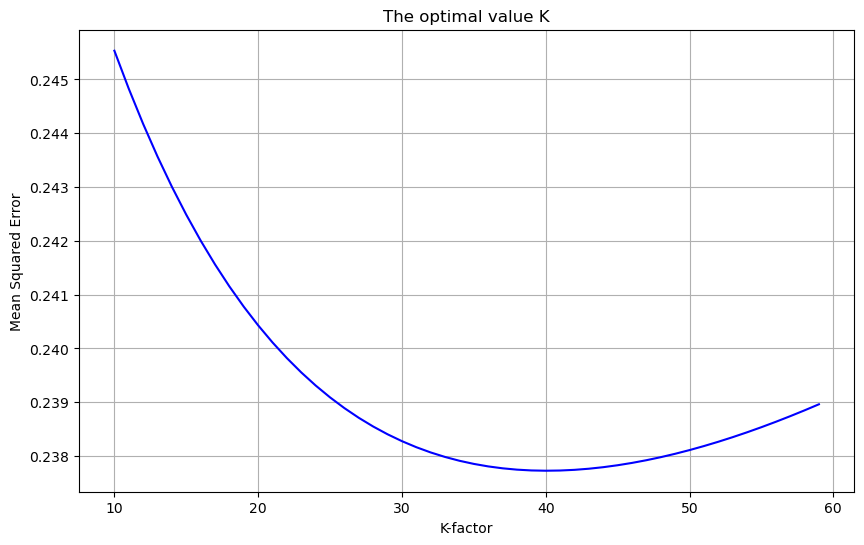

Оптимальное значение K-фактора: 40


In [ ]:
#БЛОК 7
compile_stats = pd.read_csv('compile_stats.csv')
goalk_df = pd.read_csv('goalkeepers_data.csv')



#Создание файла со статистикой команд за каждый матч
crt_game_stats(compile_stats, goalk_df, df_game_history)

#Поиск оптимального K
optimal_k = find_optimal_k_factor('game_stats_one_r.csv')
print("Оптимальное значение K-фактора:", optimal_k)

#Вычисление ELO рейтинга с найденным K
game_stats = calculate_elo('game_stats_one_r.csv',optimal_k)
game_stats.to_csv('game_stats_one_r.csv', index=False, float_format='%.2f')

In [ ]:
#Вычисление интегрального рейтинга

Таблица mean_goalk_stats успешно сохранена в файле mean_stats_goalk.csv
Таблица mean_stats_pl успешно сохранена в файле mean_stats_pl.csv

Общие статистики по показателям для амплуа 10(нападающие):
ID player    5673.490879
amplua         10.000000
time           15.055644
G               0.350818
As              0.243886
TB              1.363543
Shot            2.286495
BT              0.283798
pm             -0.098983
dtype: float64

Общие статистики по показателям для амплуа 9(защитники):
ID player    5411.768130
amplua          9.000000
time           16.053187
G               0.120324
As              0.145105
TB              1.126803
Shot            1.219027
BT              0.620773
pm             -0.187777
dtype: float64

Общие статистики по показателям для амплуа 8(вратари):
ID player    5216.267206
MisG            4.261632
TotalTr        25.937651
ReflSh              -inf
dtype: float64


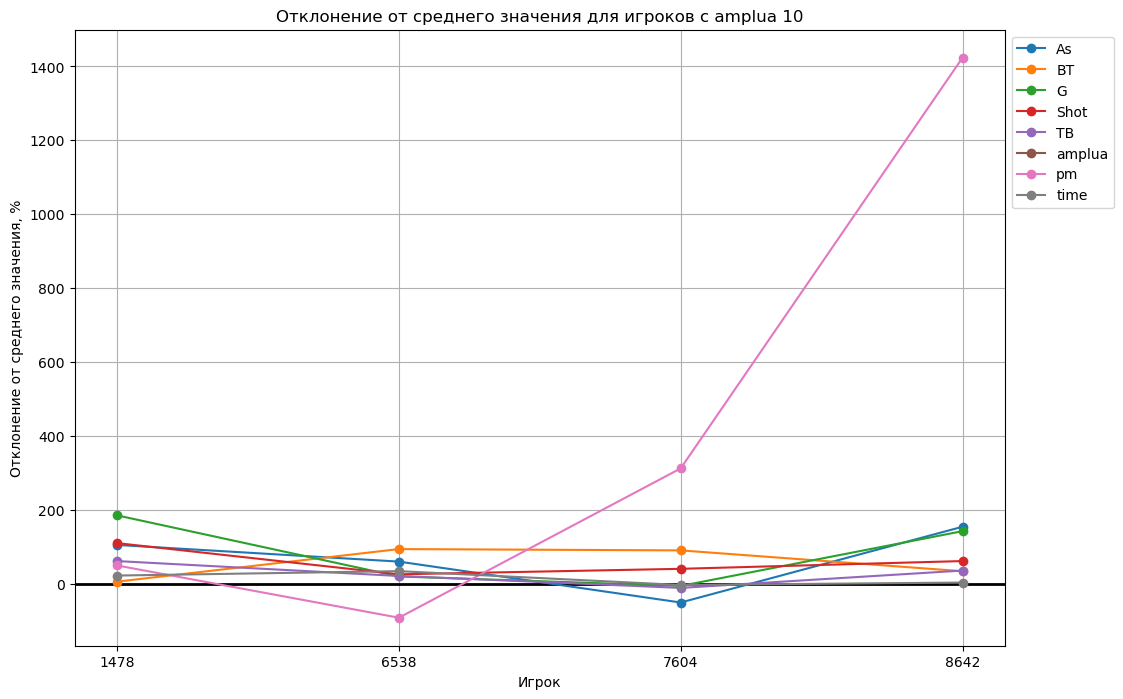

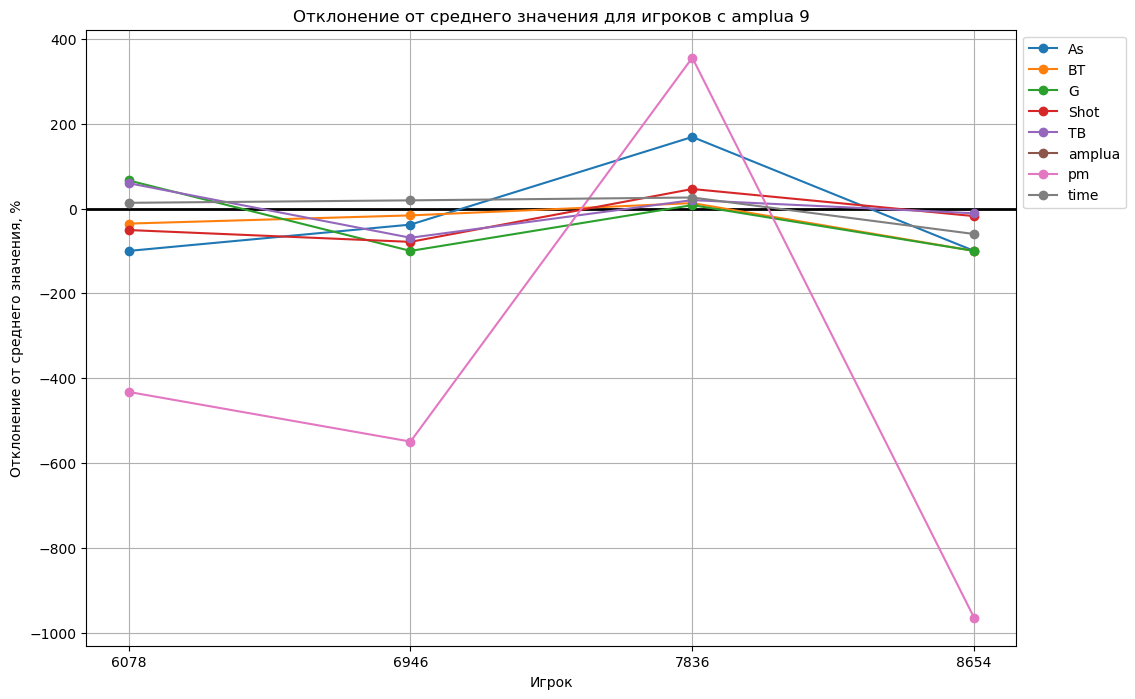

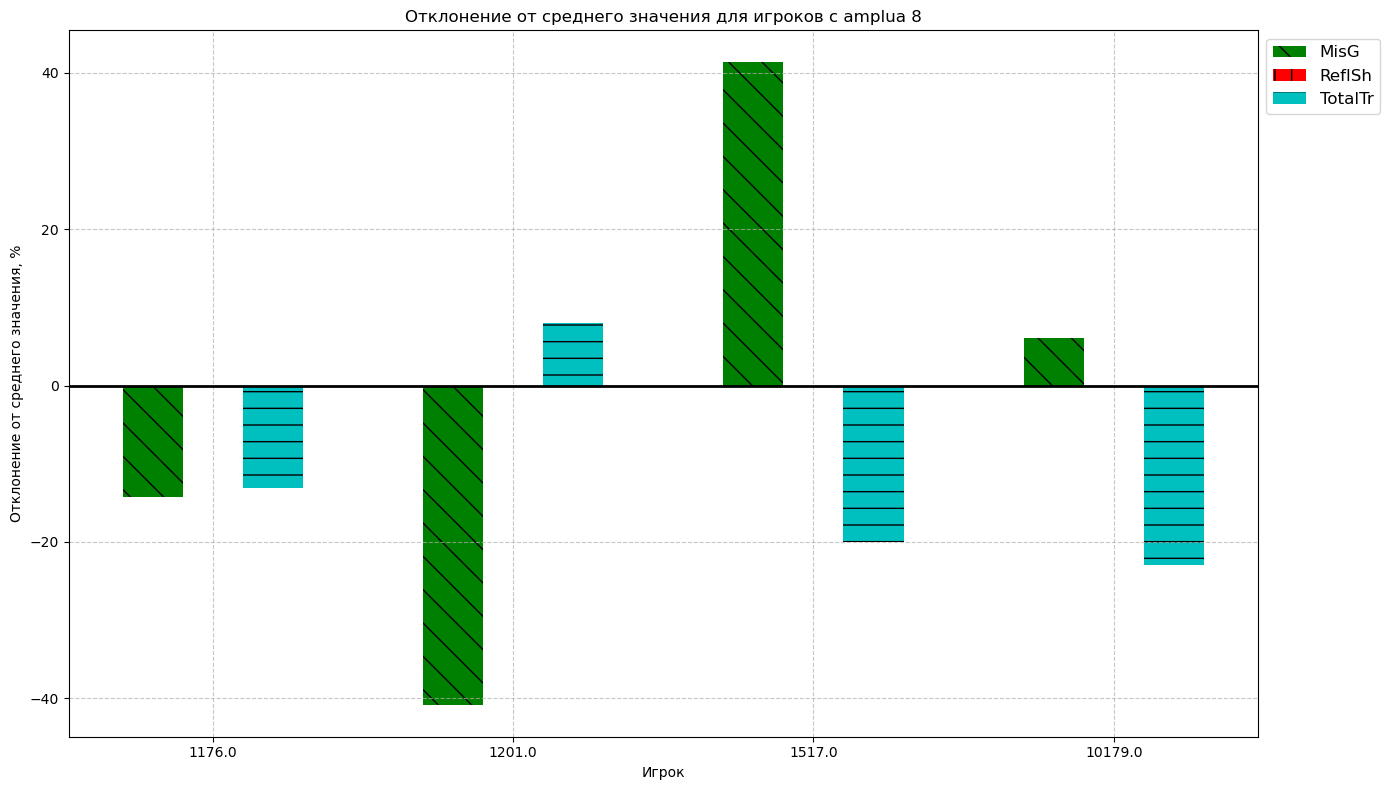

Результаты работы фнукции form_latest_teams:
Количество уникальных команд: 130
   ID game  ID team  ID opponent result   GT  timeT  TB_T  ShotT  BT_T  PM_T  \
0     7263      208          187      L  1.0  12982    18     28     1 -30.0   
1     7264      333          109      W  7.0  13044    26     36     8  25.0   
2     7265      129           23      L  3.0  12098    24     25     3   0.0   
3     7268      403          441      L  1.0  12411    20     25     9 -25.0   
4     7270      132           61      W  5.0  12873    19     22     2  14.0   

   ...     ELO   ELO_O  E_S  E_S_O  ELO_old  ELO_O_old  rating_T  \
0  ...  1480.0  1520.0  0.5    0.5   1500.0     1500.0      0.01   
1  ...  1520.0  1480.0  0.5    0.5   1500.0     1500.0      0.01   
2  ...  1280.0  1320.0  0.5    0.5   1300.0     1300.0      0.02   
3  ...  1280.0  1320.0  0.5    0.5   1300.0     1300.0      0.01   
4  ...  1120.0  1080.0  0.5    0.5   1100.0     1100.0      0.01   

   old_rating_T  rating_O  old_

In [ ]:
#БЛОК 8
goalk_data_games = pd.read_csv('goalkeepers_data.csv')

mean_stats_goalk = calculate_mean_goalk_stats(goalk_data_games)
mean_stats_goalk.to_csv('rating_last_time/mean_stats_goalk.csv', index=False, float_format='%.2f')

print("Таблица mean_goalk_stats успешно сохранена в файле mean_stats_goalk.csv")

########################################################################################
compile_stats = pd.read_csv('compile_stats.csv')

mean_player_stats = calculate_mean_player_stats(compile_stats)
mean_player_stats.to_csv('rating_last_time/mean_stats_pl.csv', index=False, float_format='%.2f')

print("Таблица mean_stats_pl успешно сохранена в файле mean_stats_pl.csv")
########################################################################################
mean_stats_pl = pd.read_csv('rating_last_time/mean_stats_pl.csv')

overall_stats_amplua_10, overall_stats_amplua_9 = calculate_overall_stats(mean_stats_pl)

print("\nОбщие статистики по показателям для амплуа 10(нападающие):")
print(overall_stats_amplua_10)

print("\nОбщие статистики по показателям для амплуа 9(защитники):")
print(overall_stats_amplua_9)
#########################################################################################
# Рассчитываем общие статистики для амплуа вратарей
overall_stats_amplua_8 = mean_stats_goalk.mean()

print("\nОбщие статистики по показателям для амплуа 8(вратари):")
print(overall_stats_amplua_8)

###########################################################################################
mean_stats_pl = pd.read_csv('rating_last_time/mean_stats_pl.csv')
mean_stats_goalk = pd.read_csv('rating_last_time/mean_stats_goalk.csv')

# Построение графиков для игроков с amplua 10
plot_player_deviation(mean_stats_pl, amplua=10, player_ids=[1478, 7604, 6538, 8642])
# Построение графиков для игроков с amplua 9
plot_player_deviation(mean_stats_pl, amplua=9, player_ids=[7836, 6078, 6946, 8654])
###########################################################################################
# Построение графиков для вратарей
plot_goalk_deviation(mean_stats_goalk, num_players=4, random_state=11)
#########################################################################################

######################################################################################################################
mean_stats_pl = pd.read_csv('rating_last_time/mean_stats_pl.csv')
mean_stats_goalk = pd.read_csv('rating_last_time/mean_stats_goalk.csv')

# Вызов функции для рассчета и добавления отклонений полевых
mean_stats_pl_with_deviations = calculate_and_add_deviations(mean_stats_pl)

# Вызов функции для рассчета и добавления отклонений ВРАТАРЕЙ
mean_stats_pl_with_deviations_goalk = calculate_and_add_deviations_goalk(mean_stats_goalk)

mean_stats_pl_with_deviations.to_csv('rating_last_time/mean_stats_deviat_1.csv', index=False, float_format='%.2f')
mean_stats_pl_with_deviations_goalk.to_csv('rating_last_time/mean_stats_deviat_GOALK_1.csv', index=False, float_format='%.2f')
#########################################################################################

latest_teams = form_latest_teams(
    compile_stats_path='compile_stats.csv',
    game_history_path=df_game_history,
    output_path='rating_last_time/latest_teams.csv'
)

    
mean_stats_deviat_1 = pd.read_csv('rating_last_time/mean_stats_deviat_1.csv')    
output_path=add_weights(mean_stats_deviat_1)
output_path.to_csv('rating_last_time/mean_stats_deviat_weights_2.csv', index=False, float_format='%.2f')

mean_stats_deviat_weights_2 = pd.read_csv('rating_last_time/mean_stats_deviat_weights_2.csv')
output_path = integral_dev(mean_stats_deviat_weights_2)
output_path.to_csv('rating_last_time/integral_rating_pl.csv', index=False, float_format='%.2f')

# Подсчет рейтинга вратаря 
####################################################################################################################
mean_stats_deviat_GOALK = pd.read_csv('rating_last_time/mean_stats_deviat_GOALK_1.csv')
mean_stats_deviat_GOALK['integral_dev'] = mean_stats_deviat_GOALK['dev_ReflSh'] * 15
mean_stats_deviat_GOALK = mean_stats_deviat_GOALK.drop(['MisG', 'TotalTr',	'ReflSh', 'dev_MisG', 'dev_ReflSh', 'dev_TotalTr'] , axis=1)
mean_stats_deviat_GOALK.to_csv('rating_last_time/rating_goalk.csv', index=False, float_format='%.2f')
####################################################################################################################

team_ratings = calculate_team_ratings_all_time(
    latest_teams_path='rating_last_time/latest_teams.csv',
    goalkeepers_data_path='rating_last_time/rating_goalk.csv',
    players_data_path='rating_last_time/integral_rating_pl.csv',
    output_path='rating_last_time/team_ratings.csv'
)

pl_rating_info_result = pl_rating_info(
    latest_teams_path='rating_last_time/latest_teams.csv',
    goalkeepers_data_path='rating_last_time/rating_goalk.csv',
    players_data_path='rating_last_time/integral_rating_pl.csv',
    output_path='rating_last_time/pl_rating_info.csv'
)


team_ratings_result = calculate_team_ratings(
    pl_rating_info_path='rating_last_time/pl_rating_info.csv',
    output_path='rating_last_time/team_bonus.csv'
)

#Расчет рейтингов за все игры
calculate_ratings(
    game_stats_file='compile_stats.csv', 
    game_history_file=df_game_history,
    goalkeepers_file='goalkeepers_data.csv', 
    output_file='all/final_ratings.csv', 
    team_output_file='all/RATING_TEAM_ALL_TIME.csv'
)

#дОБАВЛЕНИЕ СТРОКИ old_rating
add_old_ratings_to_teams(
    input_file='all/RATING_TEAM_ALL_TIME.csv', 
    output_file='all/RATING_TEAM_ALL_TIME_with_old_ratings.csv'
)


# Вызов функции с вашими файлами
add_ratings_to_game_stats(
    'all/RATING_TEAM_ALL_TIME_with_old_ratings.csv',
    'game_stats_one_r.csv',
    'game_stats_one_r.csv'
)

In [ ]:
#Модель машиннного обучения

      ID game  ID team  ID opponent result        GT     timeT      TB_T  \
0        6985      447           17      W  0.421053  0.707878  0.311111   
1        6986        1           46      W  0.315789  0.691741  0.355556   
2        6987        4           56      L  0.157895  0.635389  0.288889   
3        7201      207           26      L  0.000000  0.624407  0.244444   
4        7203      441          214      L  0.210526  0.662250  0.333333   
...       ...      ...          ...    ...       ...       ...       ...   
1512    10134      214          331      W  0.368421  0.691792  0.377778   
1513    10140      402           44      L  0.000000  0.601052  0.688889   
1514    10145      333          452      W  0.263158  0.690606  0.533333   
1515    10147      215          104      L  0.052632  0.620437  0.377778   
1516    10119       46           17      L  0.105263  0.688596  0.400000   

         ShotT      BT_T      PM_T  ...       ELO     ELO_O       E_S  \
0     0.388889

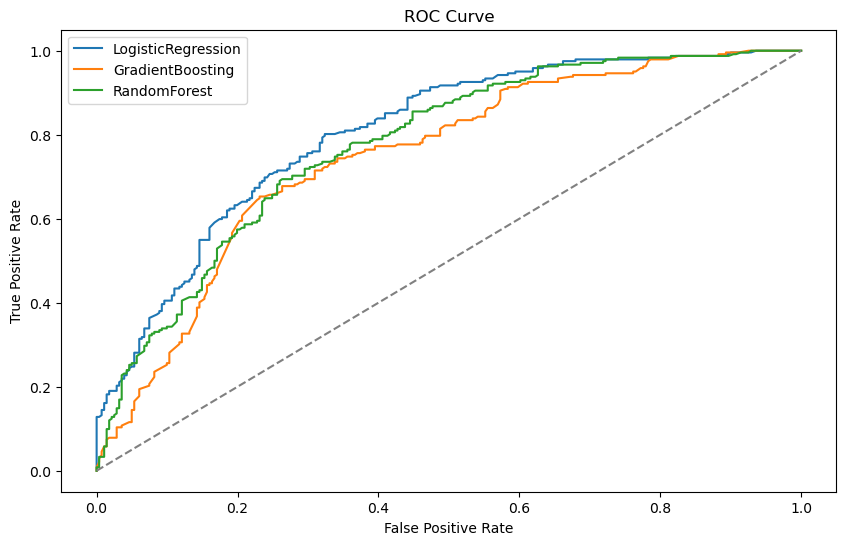

Вероятность победы команды 501 в процентах: 84.93%
Вероятность победы команды 453 в процентах: 15.07%
Вероятность победы команды 38 над командой 453: 92.84%
Вероятность победы команды 38 над командой 61: 84.04%
Вероятность победы команды 38 над командой 445: 83.35%
Вероятность победы команды 38 над командой 401: 80.94%
Вероятность победы команды 38 над командой 400: 79.09%
Вероятность победы команды 38 над командой 545: 77.74%
Вероятность победы команды 38 над командой 546: 76.41%
Вероятность победы команды 38 над командой 501: 70.79%
Вероятность победы команды 38 над командой 451: 66.74%
Вероятность победы команды 38 над командой 544: 63.44%
Вероятность победы команды 38 над командой 110: 62.74%
Вероятность победы команды 38 над командой 404: 61.36%
Вероятность победы команды 38 над командой 332: 59.69%
Вероятность победы команды 38 над командой 499: 56.89%
Вероятность победы команды 38 над командой 439: 56.85%
Вероятность победы команды 38 над командой 448: 54.81%
Вероятность победы 

['MODEL.pkl']

In [ ]:
#БЛОК 9
# нормализации данных
df = pd.read_csv('game_stats_one_r.csv')
matches = scale_and_select_features(df)
print(matches)

# Преобразовать столбец "result"
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})

# вызов функции для получения обучающих и тестовых данных
cutoff_date = '2023-10-28' #обучающие до тестовые после
xTrain, yTrain, xTest, yTest = GetTrainingData(matches, cutoff_date)


# Получение данных
xTrain, yTrain, xTest, yTest = GetTrainingData(matches, cutoff_date)

# Гиперпараметры для GradientBoostingClassifier
gb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200]
}

# Гиперпараметры для RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
# Задаем сетку гиперпараметров
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}

# Создание и обучение новых моделей с подбором гиперпараметров
new_models = {
    "LogisticRegression": GridSearchCV(LogisticRegression(solver='sag', max_iter=10000), param_grid, cv=5, scoring='accuracy'),
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=5, scoring='accuracy'),
    "RandomForest": GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')
}

new_results = {}
for name, model in new_models.items():
    model.fit(xTrain, yTrain)
    y_pred = model.predict(xTest)
    y_pred_proba = model.predict_proba(xTest)[:, 1]  # Вероятность победы команды 1
    
    accuracy = accuracy_score(yTest, y_pred)
    auc = roc_auc_score(yTest, y_pred_proba)
    
    new_results[name] = {"Accuracy": accuracy, "AUC": auc}

# Вывод результатов новых моделей
print("Performance of New Models:")
for name, result in new_results.items():
    print(f"{name}: Accuracy={result['Accuracy']:.4f}, AUC={result['AUC']:.4f}")

# Графики ROC-кривых для новых моделей
plt.figure(figsize=(10, 6))
for name, model in new_models.items():
    y_pred_proba = model.predict_proba(xTest)[:, 1]
    fpr, tpr, _ = roc_curve(yTest, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#ПРИМЕР: проверка шансов на победу двух комапнд
# Пример ID команд
team1_id = 501
team2_id = 453

# Получение вероятности победы команды 1
win_probability_lr1 = get_team_win_probability(team1_id, team2_id)
win_probability_lr2 = get_team_win_probability(team2_id, team1_id)

# Получение вероятностей
probabilities = [win_probability_lr1, win_probability_lr2]

# Нормализация вероятностей
normalized_probs = normalize_probabilities(probabilities)

# Вывод процентов
for team_id, prob in zip([team1_id, team2_id], normalized_probs):
    print(f"Вероятность победы команды {team_id} в процентах: {prob * 100:.2f}%")

#ПРИМЕР: проверки шансов на победы КОМАНДЫ против ВСЕХ остальных команд
team_id = 38  # ID вашей команды
win_probabilities = get_team_win_probabilities(team_id, matches)

# Сортировка вероятностей по убыванию
sorted_win_probabilities = sorted(win_probabilities.items(), key=lambda x: x[1], reverse=True)

# Вывод вероятностей победы вашей команды над каждой из других команд, отсортированных по вероятности
for opp_team_id, prob in sorted_win_probabilities:
    print(f"Вероятность победы команды {team_id} над командой {opp_team_id}: {prob * 100:.2f}%")

# Сохранение обученной модели
joblib.dump(new_models["LogisticRegression"], 'MODEL.pkl')

In [ ]:
#Создать таблицу актуальных рейтингов

In [ ]:
#БЛОК 10
#делаем таблицу ЭЛО
def print_elo_ratings_with_division_and_games(game_stats):
    team_data = []

    team_ids = game_stats['ID team'].unique()

    # Для каждой команды находим ее последний ELO рейтинг и количество сыгранных матчей
    for team_id in team_ids:
        # Выбираем записи только для текущей команды
        team_matches = game_stats[(game_stats['ID team'] == team_id) | (game_stats['ID opponent'] == team_id)]

        # Выбираем запись с последним матчем для текущей команды
        last_match = game_stats[game_stats['ID team'] == team_id].iloc[-1]

        # Получаем ELO рейтинг и номер дивизиона для текущей команды
        elo_rating = last_match['ELO']
        division = last_match['division']

        # Получаем количество сыгранных матчей для текущей команды
        num_matches = len(team_matches)

        # Добавляем данные о команде в список
        team_data.append({'ID team': team_id, 'ELO': elo_rating, 'Division': division, 'Matches': num_matches})

    # Создаем DataFrame из списка данных о командах
    elo_division_games_df = pd.DataFrame(team_data)

    # Сортируем DataFrame по ELO рейтингу
    elo_division_games_df = elo_division_games_df.sort_values(by='ELO')

    elo_division_games_df.to_csv('_Temp_df/ELO_df.csv', index=False)
    
game_stats = pd.read_csv('game_stats_one_r.csv')
print_elo_ratings_with_division_and_games(game_stats)

itog_dev_sum = pd.read_csv('rating_last_time/team_bonus.csv')
team_ratings = pd.read_csv('_Temp_df/ELO_df.csv')
teams_name = pd.read_csv('_Sources_df/teams_name_utf8.csv')

# Объединяем таблицы по ID team
team_ratings = team_ratings.merge(itog_dev_sum[['ID team', 'PL_RATING']], on='ID team')

team_ratings.insert(2, 'ELO', team_ratings.pop('ELO'))

# Сортировка по 'Division' (возрастание) и 'ELO' (убывание)
team_ratings = team_ratings.sort_values(by=['Division', 'ELO'], ascending=[True, False])

#team_ratings = team_ratings.sort_values(by='Division')

team_ratings = team_ratings.merge(teams_name[['ID team', 'TEAM_NAME']], on='ID team')

# Удаление столбцов "солбики" и "ID team"
#team_ratings.drop(columns=['ID team'], inplace=True)

new_order = ['ID team', 'TEAM_NAME', 'Division', 'ELO', 'PL_RATING', 'Matches']

team_ratings = team_ratings[new_order]

#ТУТ БУДЕТ ТАБЛИЦА КОТОРАЯ ХРАНИТ В СЕБЕ АКТУЛЬНУЮ ИНФОРМАЦИЮ О КОМАНДАХ
team_ratings.to_csv('team_ratings_merge.csv', index=False)
######################################################################################################################################################

In [ ]:
#Распределение команд

In [ ]:
#БЛОК 11
# Загрузка данных из файла game_stats_one_r_with_ratings.csv
game_stats = pd.read_csv("game_stats_one_r.csv")

# Получение уникальных значений в столбце ID season
unique_season_ids = game_stats['ID season'].unique()

# Вывод уникальных значений
print("Уникальные значения в столбце ID season:")
print(unique_season_ids)

Уникальные значения в столбце ID season:
[68. 67. 70. 73. 75. 74. 82.]


In [ ]:
#БЛОК 12
season = 73
game_before_season, unique_teams = process_season_data(season)

print("Уникальные команды и их дивизионы в текущем сезоне:", unique_teams)

Уникальные команды и их дивизионы в текущем сезоне:      ID team  division
795      335         1
796      402         1
798      269         1
799      451         3
801      400         3
802      411         2
803      448         2
804       15         0
806      409         1
807      329         1
808       44         1
810      449         3
811      215         3
813      214         1
814      176         3
815      333         0
816      189         0
825      404         2
827      452         0
828      401         3
835       12         0
843      332         2
845      438         2
847      431         3
852       23         1
801      406         3
802      439         2


In [ ]:
#КОД ДЛЯ ОЦЕНИВАНИЯ РАСПРЕДЕЛЕНЯИ КОМАНД ПО ДИВЗИИОНАМ

In [ ]:
#БЛОК 13
# тут идет оценка распределния ЛИГИ
season = 73

game_before_season, unique_teams = process_season_data(season)
matches = scale_and_select_features(game_before_season)
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})
# Преобразование данных в структуру division_teams
division_teams = unique_teams.groupby('division')['ID team'].apply(list).to_dict()

match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатов в CSV файл
match_results_df.to_csv('_Temp_df/simulated_matches.csv', index=False)

# Вывод количества команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Дивизион: 0, Количество команд: 5, Количество матчей: 10
Дивизион: 1, Количество команд: 8, Количество матчей: 28
Дивизион: 2, Количество команд: 6, Количество матчей: 15
Дивизион: 3, Количество команд: 8, Количество матчей: 28
Среднее значение наибольших вероятностей для каждого дивизиона:
division
0    81.283580
1    65.567364
2    67.247062
3    65.300832
dtype: float64


In [ ]:
#БЛОК 14
#Тут мы пытаемся ранжировать команды лучше чем лига, последние два аргумента это кол-во дивизонов и мин. кол-во команд в одном дивизионе
rank_teams(unique_teams, 'MODEL.pkl', num_divisions=4, min_teams_per_division=5)
#Эта функция создает файл team_rangirov в котором команды распределены, и снизу мы даем оценку этому распределению

Количество уникальных команд: 27


In [ ]:
#БЛОК 15
# Загрузка данных из team_rangirov.csv
team_rangirov = pd.read_csv('team_rangirov.csv')

# Преобразование данных в структуру division_teams
division_teams = team_rangirov.groupby('division')['ID team'].apply(list).to_dict()

# Выполнение симуляции матчей и вычисление средних наибольших вероятностей
match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатовл
match_results_df.to_csv('_Temp_df/simulated_matches.csv', index=False)

# Вывод кол-ва команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Дивизион: Division 1, Количество команд: 7, Количество матчей: 21
Дивизион: Division 2, Количество команд: 7, Количество матчей: 21
Дивизион: Division 3, Количество команд: 7, Количество матчей: 21
Дивизион: Division 4, Количество команд: 6, Количество матчей: 15
Среднее значение наибольших вероятностей для каждого дивизиона:
division
Division 1    59.925735
Division 2    68.209013
Division 3    62.937049
Division 4    52.786909
dtype: float64


In [ ]:
#Ранжирование тех команд которые сами хотим распределить, тоесть создали сами таблицу с командами, например которые будут в новом дивизионе

In [ ]:
#тут мы создали табилцу с командами  и их последними двизионами team_for_rangir, и ранжируем их нашим алгоритмом

In [ ]:
#БЛОК 16
unique_teams = pd.read_excel('team_for_rangir.xlsx') #"ручная" таблица
data_team = pd.read_csv('game_stats_one_r.csv') # файл со статитстикой

matches = scale_and_select_features(data_team)
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})
######################################################################################
#Вызов функции для автоматического распределения 
rank_teams(unique_teams, 'MODEL.pkl', num_divisions=2, min_teams_per_division=4)
######################################################################################
team_rangirov = pd.read_csv('team_rangirov.csv')

# Преобразование данных в структуру division_teams
division_teams = team_rangirov.groupby('division')['ID team'].apply(list).to_dict()

match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатов в CSV файл
match_results_df.to_csv('_Temp_df/simulated_matches.csv', index=False)

# Вывод количества команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Количество уникальных команд: 8
Дивизион: Division 1, Количество команд: 4, Количество матчей: 6
Дивизион: Division 2, Количество команд: 4, Количество матчей: 6
Среднее значение наибольших вероятностей для каждого дивизиона:
division
Division 1    58.488896
Division 2    61.680932
dtype: float64


In [ ]:
# тут мы просто оцениваем наше РУЧНОЕ ранжирование, тоесть если сами руками распределлил команды, и хотип узнать насколько хорошо

In [ ]:
unique_teams = pd.read_excel('team_for_rangir.xlsx') # "ручная" таблица
data_team = pd.read_csv('game_stats_one_r.csv')

matches = scale_and_select_features(data_team)
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})

# Преобразование данных в структуру division_teams
division_teams = unique_teams.groupby('division')['ID team'].apply(list).to_dict()

match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатов в CSV файл
match_results_df.to_csv('_Temp_df/simulated_matches.csv', index=False)

# Вывод количества команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Дивизион: 0, Количество команд: 4, Количество матчей: 6
Дивизион: 2, Количество команд: 4, Количество матчей: 6
Среднее значение наибольших вероятностей для каждого дивизиона:
division
0    71.503834
2    74.120918
dtype: float64
